## Business Problem

## Bottom Line Up Front (BLUF)

Phishing emails will most always make it through in one way or another.  Once one is prevented, someone will find a new way to squeek it through.  So it is always important to be as cautious as possible when clicking on an unknown or suspicous link.  However, the model we have created below is good at filtering out phishing URL's at a 99% rate.  It may not be perfect, but it sure eliminates a lot of the threats out there.

## For Your Information About the Data

I originally trained the data on one dataset that had 55 columns - came out to be 99.9% accurate.  On another dataset of only 100 URL's it was 52% accurate, predicting almost all URL's as phishing.  Because of this, I used two seperate datasets to train a model.  The dataset only consists of about 10k URL's, but works at about 99% on the remaining untrained 200k URL's from the original dataset. 

## Tableau Dashboard Link

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
import re
import pickle
import scipy
from scipy.stats import randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from Phishing_Features_Class import PhishingFeatureExtractor


## Data Loading

In [2]:
phish_df = pd.read_csv("Data/PhiUSIIL_Phishing_URL_Dataset.csv")

## Exploratory Data Analysis

In [3]:
phish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [4]:
phish_df.describe()

URLLength   DomainLength     IsDomainIP  URLSimilarityIndex  \
count  235795.000000  235795.000000  235795.000000       235795.000000   
mean       34.573095      21.470396       0.002706           78.430778   
std        41.314153       9.150793       0.051946           28.976055   
min        13.000000       4.000000       0.000000            0.155574   
25%        23.000000      16.000000       0.000000           57.024793   
50%        27.000000      20.000000       0.000000          100.000000   
75%        34.000000      24.000000       0.000000          100.000000   
max      6097.000000     110.000000       1.000000          100.000000   

       CharContinuationRate  TLDLegitimateProb    URLCharProb      TLDLength  \
count         235795.000000      235795.000000  235795.000000  235795.000000   
mean               0.845508           0.260423       0.055747       2.764456   
std                0.216632           0.251628       0.010587       0.599739   
min                0.000000           0.000000       0.001083       2.000000   
25%                0.680000           0.005977       0.050747       2.000000   
50%                1.000000           0.079963       0.057970       3.000000   
75%                1.000000           0.522907       0.062875       3.000000   
max                1.000000           0.522907       0.090824      13.000000   

       NoOfSubDomain  HasObfuscation  ...            Pay         Crypto  \
count  235795.000000   235795.000000  ...  235795.000000  235795.000000   
mean        1.164758        0.002057  ...       0.237007       0.023474   
std         0.600969        0.045306  ...       0.425247       0.151403   
min         0.000000        0.000000  ...       0.000000       0.000000   
25%         1.000000        0.000000  ...       0.000000       0.000000   
50%         1.000000        0.000000  ...       0.000000       0.000000   
75%         1.000000        0.000000  ...       0.000000       0.000000   
max        10.000000        1.000000  ...       1.000000       1.000000   

       HasCopyrightInfo      NoOfImage        NoOfCSS         NoOfJS  \
count     235795.000000  235795.000000  235795.000000  235795.000000   
mean           0.486775      26.075689       6.333111      10.522305   
std            0.499826      79.411815      74.866296      22.312192   
min            0.000000       0.000000       0.000000       0.000000   
25%            0.000000       0.000000       0.000000       0.000000   
50%            0.000000       8.000000       2.000000       6.000000   
75%            1.000000      29.000000       8.000000      15.000000   
max            1.000000    8956.000000   35820.000000    6957.000000   

         NoOfSelfRef   NoOfEmptyRef  NoOfExternalRef          label  
count  235795.000000  235795.000000    235795.000000  235795.000000  
mean       65.071113       2.377629        49.262516       0.571895  
std       176.687539      17.641097       161.027430       0.494805  
min         0.000000       0.000000         0.000000       0.000000  
25%         0.000000       0.000000         1.000000       0.000000  
50%        12.000000       0.000000        10.000000       1.000000  
75%        88.000000       1.000000        57.000000       1.000000  
max     27397.000000    4887.000000     27516.000000       1.000000  

[8 rows x 51 columns]

In [5]:
phish_df.head(40)

FILENAME                                                URL  \
0     521848.txt                   https://www.southbankmosaics.com   
1      31372.txt                           https://www.uni-mainz.de   
2     597387.txt                     https://www.voicefmradio.co.uk   
3     554095.txt                        https://www.sfnmjournal.com   
4     151578.txt                 https://www.rewildingargentina.org   
5      23107.txt                    https://www.globalreporting.org   
6      23034.txt                         https://www.saffronart.com   
7     696732.txt                         https://www.nerdscandy.com   
8     739255.txt                     https://www.hyderabadonline.in   
9      14486.txt                                https://www.aap.org   
10    167350.txt                 https://www.religionenlibertad.com   
11   mw42508.txt                            http://www.teramill.com   
12    515489.txt                       https://www.socialpolicy.org   
13    858208.txt                              https://www.aoh61.com   
14    712305.txt                        https://www.bulgariaski.com   
15    252332.txt                          https://www.brightika.com   
16    862789.txt                              https://www.motley.ie   
17    561324.txt                             https://www.funzine.hu   
18    791831.txt                             https://www.dixxon.com   
19    861208.txt                            https://www.ooty.ind.in   
20   mw16985.txt                        http://www.f0519141.xsph.ru   
21  mw131249.txt                           http://www.shprakserf.gq   
22      6569.txt                      https://www.cryptocompare.com   
23    394270.txt                     https://www.diariodealmeria.es   
24    518245.txt                 https://www.town.minamichita.lg.jp   
25    683655.txt                         https://www.bwresearch.com   
26    638225.txt              https://www.musicvideoproduction.guru   
27   7972389.txt             https://service-mitld.firebaseapp.com/   
28   mw34096.txt                  http://www.kuradox92.lima-city.de   
29   8008520.txt                        https://liuy-9a930.web.app/   
30     86745.txt                             https://www.landed.com   
31   8029912.txt  https://ipfs.io/ipfs/qmrvvyr84esa2assw9vvwupqj...   
32   8066660.txt           http://att-103731-107123.weeblysite.com/   
33     53440.txt                          https://www.bikeseoul.com   
34   8065475.txt                https://hidok4f8zl.firebaseapp.com/   
35    584755.txt                           https://www.ibeani.co.uk   
36    603823.txt                  https://www.metroretrovintage.com   
37   mw52024.txt                               http://www.ooguy.com   
38     62523.txt                               https://www.vysor.io   
39   mw74078.txt                       http://www.fairytalesinc.com   

    URLLength                            Domain  DomainLength  IsDomainIP  \
0          31          www.southbankmosaics.com            24           0   
1          23                  www.uni-mainz.de            16           0   
2          29            www.voicefmradio.co.uk            22           0   
3          26               www.sfnmjournal.com            19           0   
4          33        www.rewildingargentina.org            26           0   
5          30           www.globalreporting.org            23           0   
6          25                www.saffronart.com            18           0   
7          25                www.nerdscandy.com            18           0   
8          29            www.hyderabadonline.in            22           0   
9          18                       www.aap.org            11           0   
10         33        www.religionenlibertad.com            26           0   
11         22                  www.teramill.com            16           0   
12         27              www.socialpolicy.org            20           0   
13         20     

In [6]:
phish_df.head()

FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.666667           0.032650  ...    0   
2               100.0              0.866667           0.028555  ...    0   
3               100.0              1.000000           0.522907  ...    1   
4               100.0              1.000000           0.079963  ...    1   

   Crypto  HasCopyrightInfo  NoOfImage  NoOfCSS  NoOfJS  NoOfSelfRef  \
0       0                 1         34       20      28          119   
1       0                 1         50        9       8           39   
2       0                 1         10        2       7           42   
3       1                 1          3       27      15           22   
4       0                 1        244       15      34           72   

   NoOfEmptyRef  NoOfExternalRef  label  
0             0              124      1  
1             0              217      1  
2             2                5      1  
3             1               31      1  
4             1               85      1  

[5 rows x 56 columns]

In [7]:
phish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 56 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLD                         235795 non-null  object 
 7   URLSimilarityIndex          235795 non-null  float64
 8   CharContinuationRate        235795 non-null  float64
 9   TLDLegitimateProb           235795 non-null  float64
 10  URLCharProb                 235795 non-null  float64
 11  TLDLength                   235795 non-null  int64  
 12  NoOfSubDomain               235795 non-null  int64  
 13  HasObfuscation

In [8]:
phish_df = phish_df.drop_duplicates()

In [9]:
label_counts = phish_df['label'].value_counts()

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:1273: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)


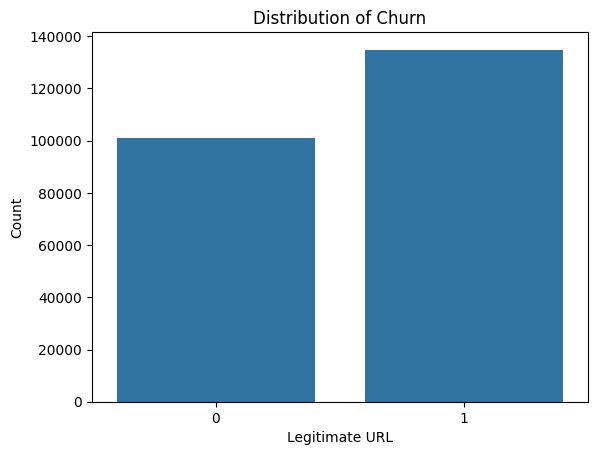

In [10]:
# Visualize (use the counts object)
X = label_counts.index
y = label_counts.values

# Code for plot provided
sns.barplot(x=X, y=y)
plt.xlabel('Legitimate URL')
plt.ylabel('Count')
plt.title("Distribution of Churn");

In [11]:
# Get all columns that have either a 0 or 1 - Boolean like columns
bool_like_cols = [col for col in phish_df.columns if phish_df[col].dropna().isin([0, 1]).all()]

#Get All numeric columns - Including the bool_like_cols
numeric_cols = phish_df.select_dtypes(include=['number']).columns

# Get non numeric columns
non_numeric_cols = phish_df.select_dtypes(exclude='number').columns

# Get Numeric columns excluding the bool like columns
pure_numeric_cols = [col for col in numeric_cols if col not in bool_like_cols]




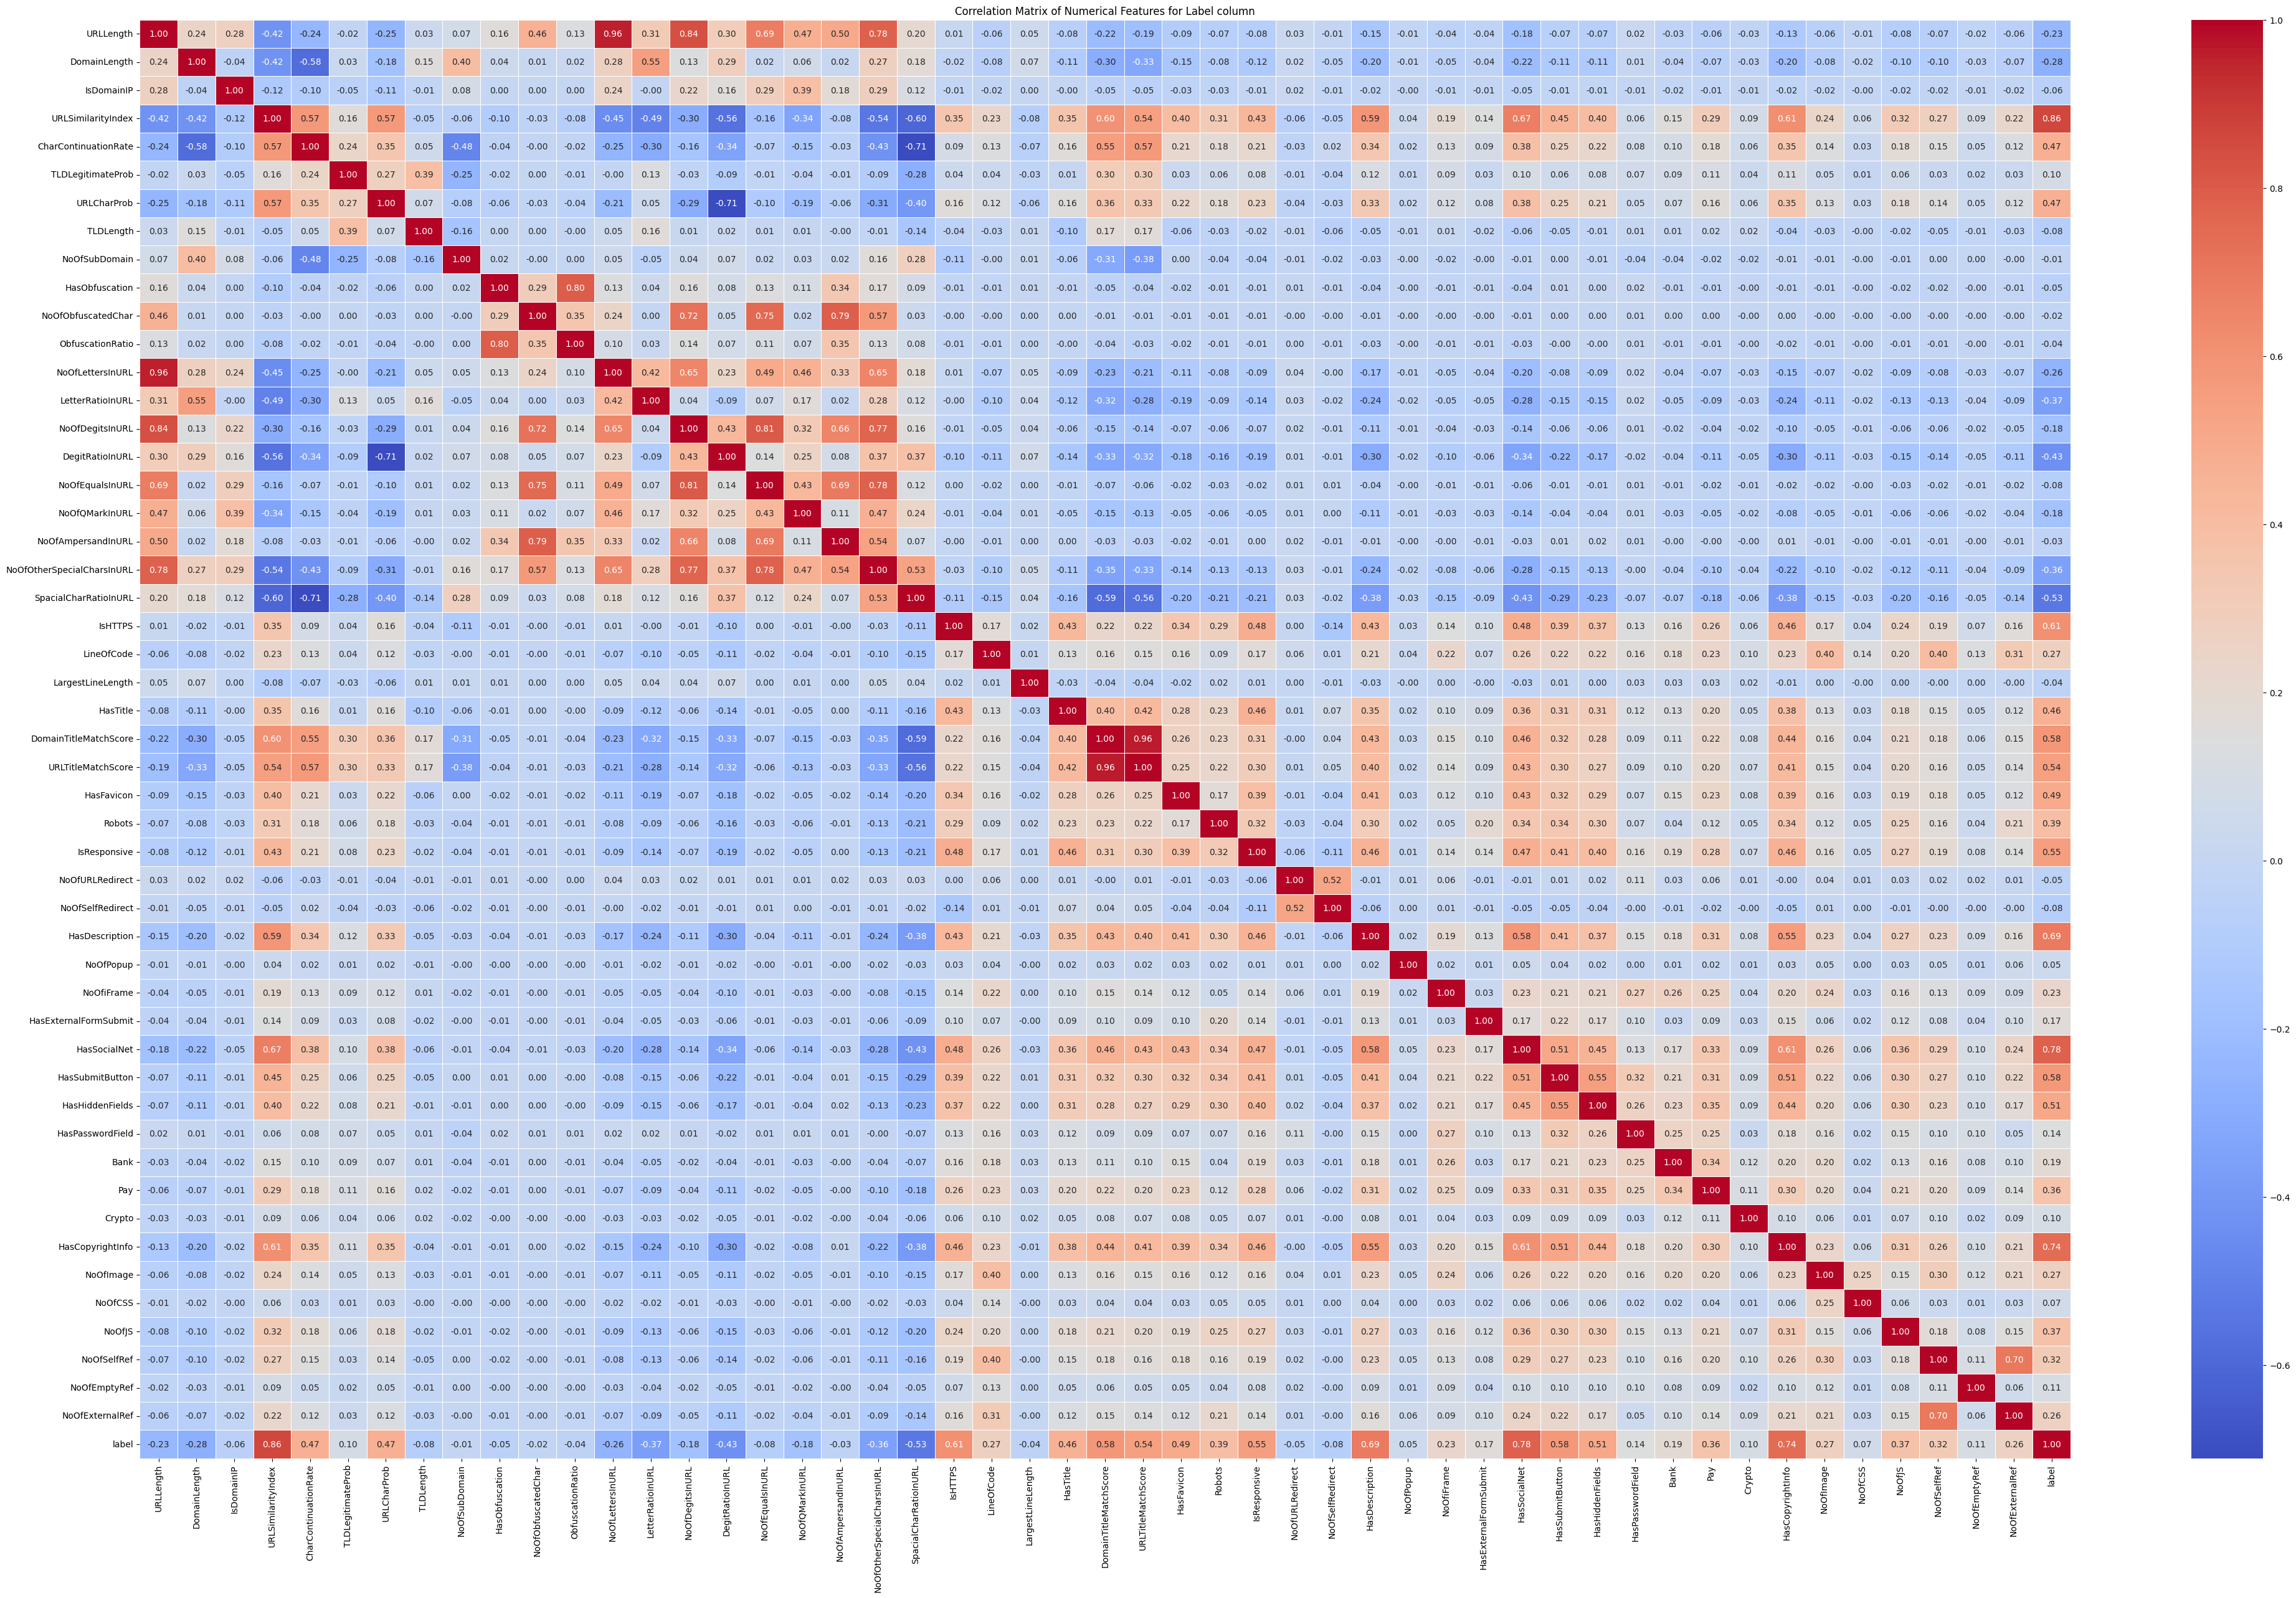

In [12]:
phish_corr = phish_df[numeric_cols].corr()
label_corr = phish_corr['label'].drop('label')

plt.figure(figsize=(50, 30))
sns.heatmap(phish_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features for Label column")
plt.show()


/tmp/ipykernel_336178/3917062377.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


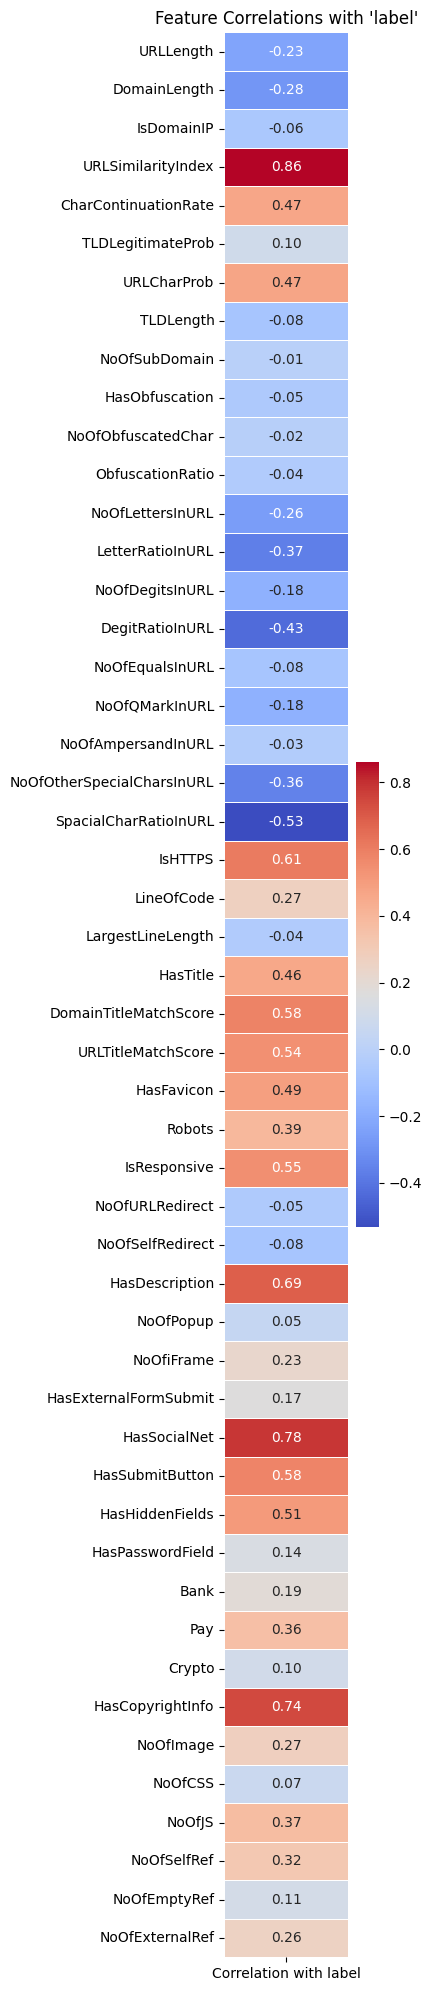

In [13]:
label_corr_df = label_corr.to_frame(name='Correlation with label')

plt.figure(figsize=(2, len(label_corr) * 0.5))
sns.heatmap(label_corr_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Feature Correlations with 'label'")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [14]:
# Individual Null Value counts
print(f"Null values:\n{phish_df.isnull().sum()}")

Null values:
FILENAME                      0
URL                           0
URLLength                     0
Domain                        0
DomainLength                  0
IsDomainIP                    0
TLD                           0
URLSimilarityIndex            0
CharContinuationRate          0
TLDLegitimateProb             0
URLCharProb                   0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
Title                         0
DomainTitleMatchScore      

In [15]:
# Total Null value counts
print(f"Total Null Values in all columns: {phish_df.isnull().sum().sum()}")

Total Null Values in all columns: 0


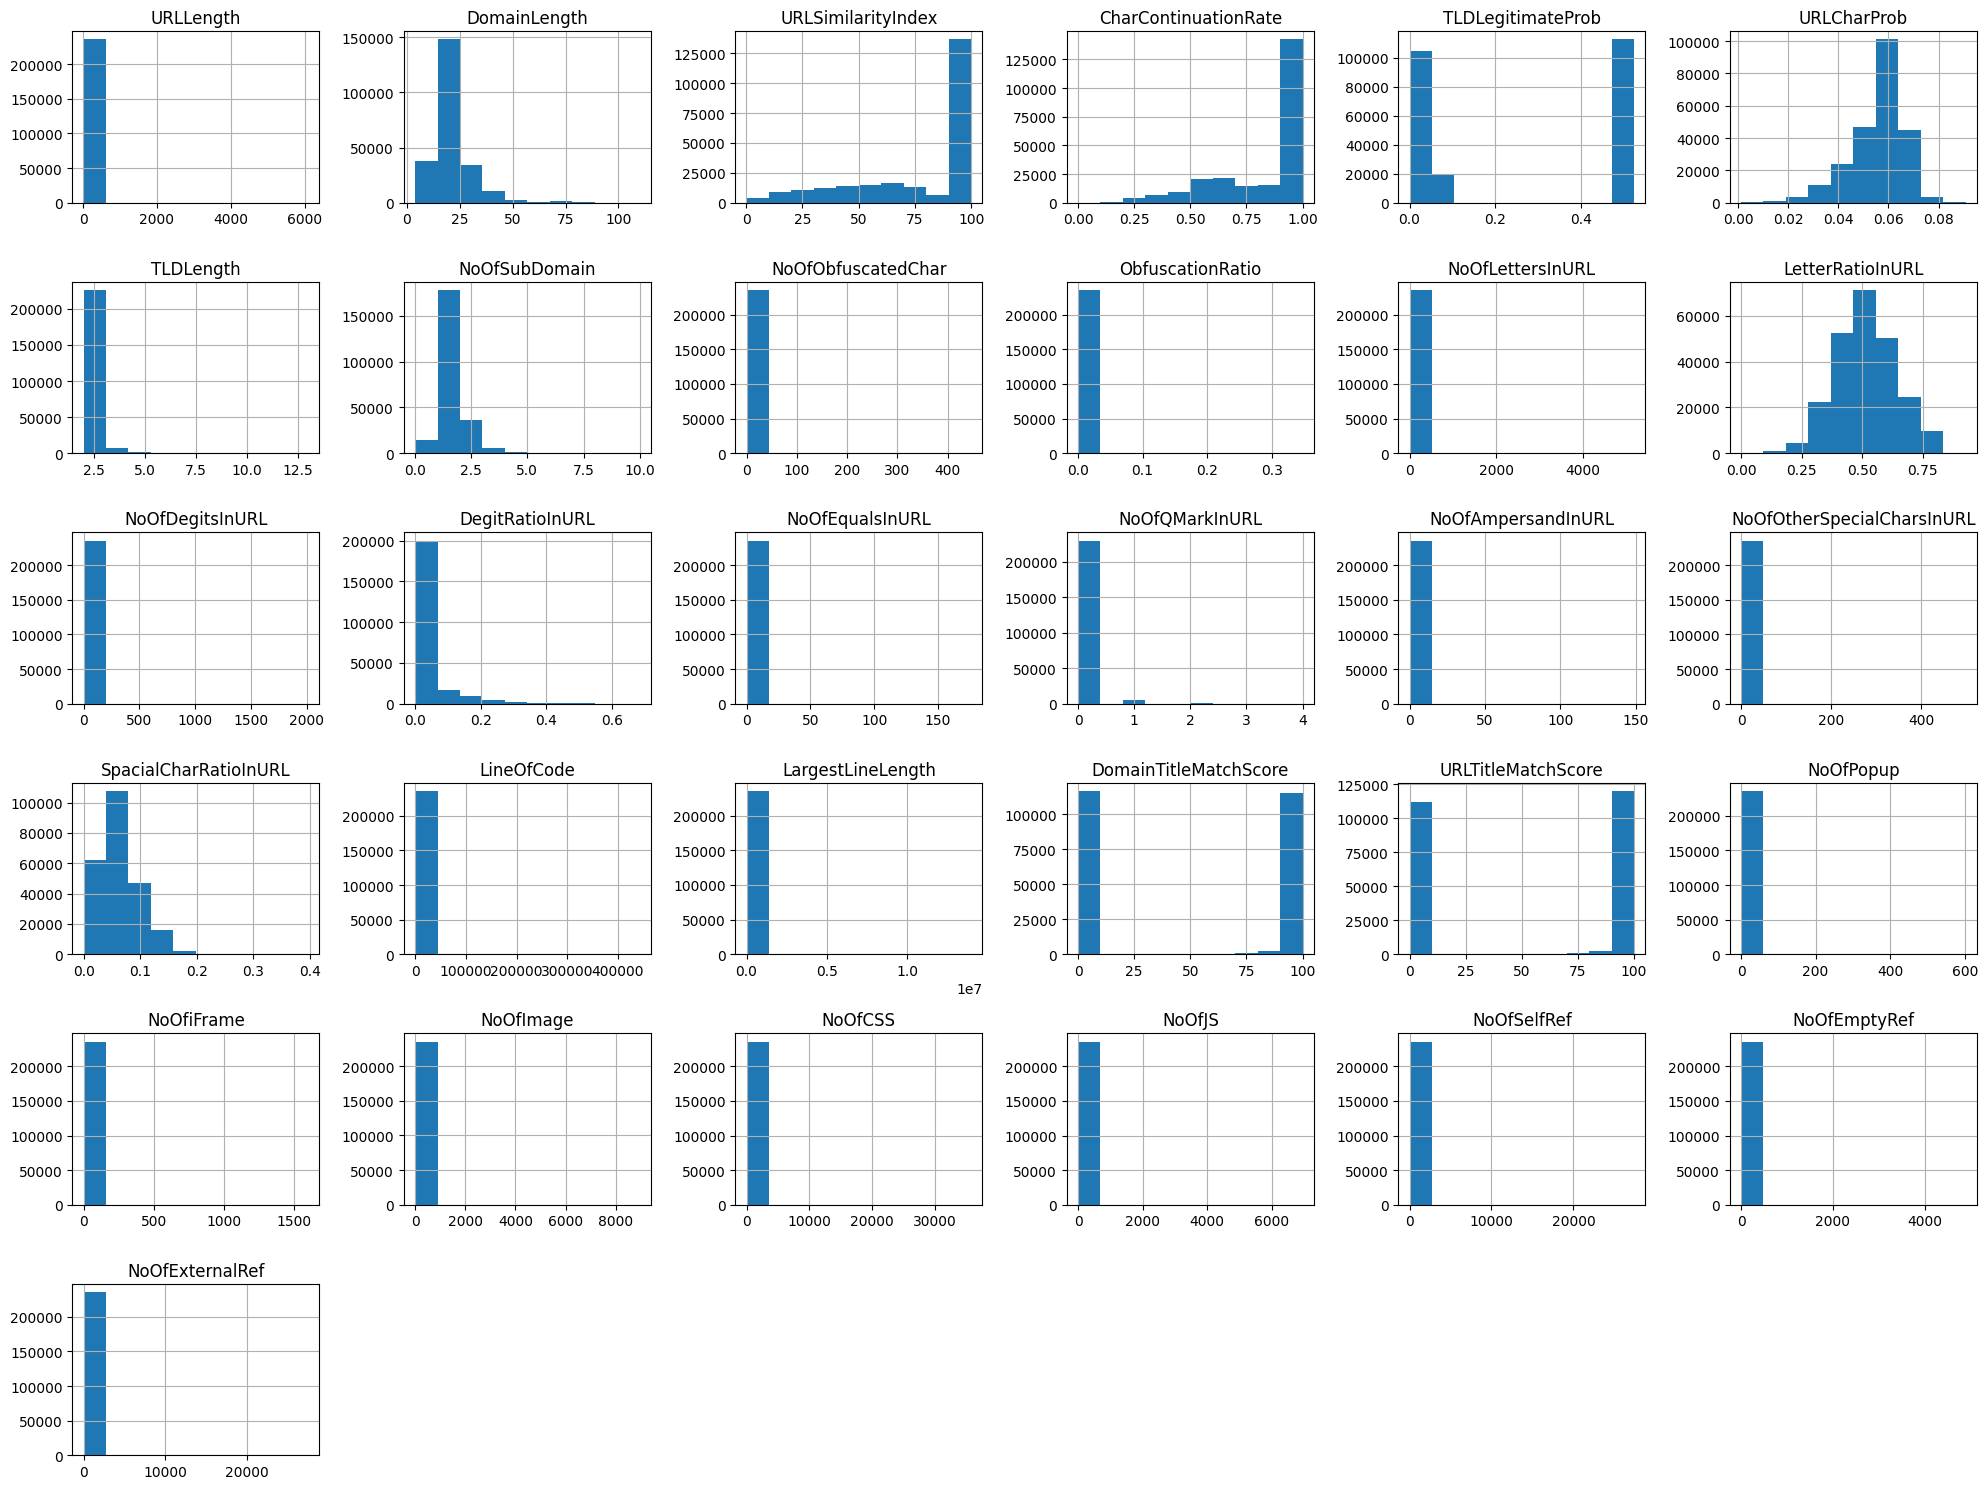

In [16]:
phish_df[pure_numeric_cols].hist(figsize=(20, 15))
plt.tight_layout()
plt.show()


In [17]:
non_numeric_cols

Index(['FILENAME', 'URL', 'Domain', 'TLD', 'Title'], dtype='object')

In [18]:
for col in non_numeric_cols:
    print(f"{col}\nUnique Values: {phish_df[col].nunique()}")


FILENAME
Unique Values: 235795
URL
Unique Values: 235370
Domain
Unique Values: 220086
TLD
Unique Values: 695
Title
Unique Values: 197874


## Data Preparation

## Below cell is necessary for recreating URLSimilarityIndex but takes about 15 minutes to run - Sorry, should have saved to a new CSV - didn't realize at the time

In [19]:
# Creating new similarity scores for testing purposes - cannot recreate the ones in the dataset, and it is the highest coefficient (strongest feature)
similarity_scores = []

for url in tqdm(phish_df['URL'], desc="Updating URLSimilarityIndex"):
    try:
        # Skip HTML request by setting fetch_soup=False
        extractor = PhishingFeatureExtractor(url, fetch_soup=False)
        score = extractor.url_similarity_index()
        similarity_scores.append(score)
    except Exception as e:
        print(f"Error processing URL: {url} → {e}")
        similarity_scores.append(0.0)  # or use np.nan if preferred


phish_df['URLSimilarityIndex'] = similarity_scores


Updating URLSimilarityIndex: 100%|██████████| 235795/235795 [15:39<00:00, 250.88it/s]


In [20]:
# View boolean column names
bool_like_cols

['IsDomainIP',
 'HasObfuscation',
 'IsHTTPS',
 'HasTitle',
 'HasFavicon',
 'Robots',
 'IsResponsive',
 'NoOfURLRedirect',
 'NoOfSelfRedirect',
 'HasDescription',
 'HasExternalFormSubmit',
 'HasSocialNet',
 'HasSubmitButton',
 'HasHiddenFields',
 'HasPasswordField',
 'Bank',
 'Pay',
 'Crypto',
 'HasCopyrightInfo',
 'label']

In [21]:
#Removing specific columns from bool_like_cols
bool_to_remove = ['Robots', 'HasDescription', 'Bank', 'Pay', 'Crypto', 'label', 'NoOfURLRedirect', 'NoOfSelfRedirect']
updated_bool_like_cols = [col for col in bool_like_cols if col not in bool_to_remove]

In [22]:
# View Numeric column names
pure_numeric_cols

['URLLength',
 'DomainLength',
 'URLSimilarityIndex',
 'CharContinuationRate',
 'TLDLegitimateProb',
 'URLCharProb',
 'TLDLength',
 'NoOfSubDomain',
 'NoOfObfuscatedChar',
 'ObfuscationRatio',
 'NoOfLettersInURL',
 'LetterRatioInURL',
 'NoOfDegitsInURL',
 'DegitRatioInURL',
 'NoOfEqualsInURL',
 'NoOfQMarkInURL',
 'NoOfAmpersandInURL',
 'NoOfOtherSpecialCharsInURL',
 'SpacialCharRatioInURL',
 'LineOfCode',
 'LargestLineLength',
 'DomainTitleMatchScore',
 'URLTitleMatchScore',
 'NoOfPopup',
 'NoOfiFrame',
 'NoOfImage',
 'NoOfCSS',
 'NoOfJS',
 'NoOfSelfRef',
 'NoOfEmptyRef',
 'NoOfExternalRef']

In [23]:
#Remove specific numeric columns
pure_cols_to_remove = ['CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'URLTitleMatchScore', 'DomainTitleMatchScore', 'NoOfPopup']
#Add 2 columns to the pure numeric columns list
updated_pure_numeric_cols = [col for col in pure_numeric_cols if col not in pure_cols_to_remove]
if "NoOfURLRedirect" not in updated_pure_numeric_cols:
    updated_pure_numeric_cols.append("NoOfURLRedirect")
if "NoOfSelfRedirect" not in updated_pure_numeric_cols:
    updated_pure_numeric_cols.append("NoOfSelfRedirect")

In [24]:
# Re-viewing the correlations after new similarity index
phish_corr2 = phish_df[numeric_cols].corr()
label_corr2 = phish_corr2['label'].drop('label')

/tmp/ipykernel_336178/159969924.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


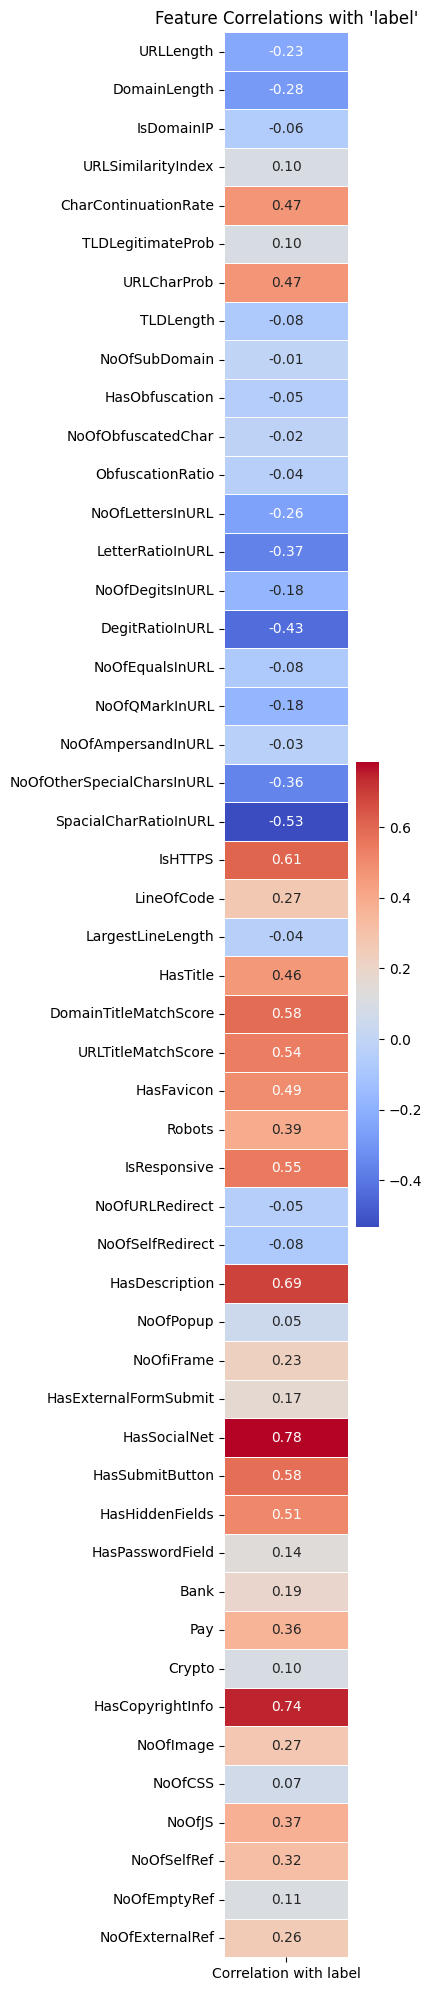

In [25]:
label_corr_df2 = label_corr2.to_frame(name='Correlation with label')

plt.figure(figsize=(2, len(label_corr2) * 0.5))
sns.heatmap(label_corr_df2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Feature Correlations with 'label'")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## PCA Testing

In [26]:
# Checking for PCA if it is useful for dataset
#Scale numeric columns
scaler = StandardScaler()
X_scaled_t = scaler.fit_transform(phish_df[updated_pure_numeric_cols])

# Create basic PCA
pca= PCA()
pca.fit(X_scaled_t)

PCA()

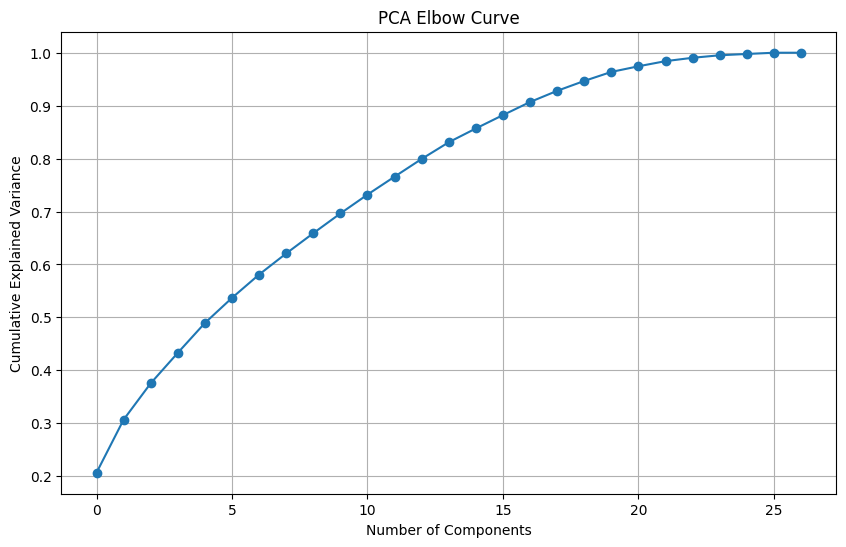

In [27]:
# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Elbow Curve')
plt.grid(True)
plt.show()


## Train Test Split

In [28]:
# 20/80 Data Split - dropping extra columns not being used
X = phish_df.drop(['label', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'Robots', 'HasDescription', 'Bank', 'Pay', 'Crypto'], axis=1)
y = phish_df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

## Pipeline

In [29]:
# Numerical Transformers for pipeline
# No PCA
numerical_transformer_all = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])




# Did not use any of the below for the model - stuck with not using PCA.  If there was more time, or wanted more effiency in the model this would have been useful.

# PCA of 90% variance
numerical_transformer_90 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9))
])

# PCA of 95% variance
numerical_transformer_95 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))
])

# PCA of 99% variance
numerical_transformer_99 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.99))
])

In [30]:
non_numeric_cols

Index(['FILENAME', 'URL', 'Domain', 'TLD', 'Title'], dtype='object')

In [31]:
phish_df[non_numeric_cols].head()

FILENAME                                 URL                      Domain  \
0  521848.txt    https://www.southbankmosaics.com    www.southbankmosaics.com   
1   31372.txt            https://www.uni-mainz.de            www.uni-mainz.de   
2  597387.txt      https://www.voicefmradio.co.uk      www.voicefmradio.co.uk   
3  554095.txt         https://www.sfnmjournal.com         www.sfnmjournal.com   
4  151578.txt  https://www.rewildingargentina.org  www.rewildingargentina.org   

   TLD                                              Title  
0  com  à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...  
1   de              johannes gutenberg-universitÃ¤t mainz  
2   uk                               voice fm southampton  
3  com  home page: seminars in fetal and neonatal medi...  
4  org                     fundaciÃ³n rewilding argentina

In [32]:
# Categorical Transformers

#TF-IDF vectorizer for the title
def squeeze_column(x):
    return x.squeeze()

reshape_title = FunctionTransformer(squeeze_column)

title_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='')),
    ('reshape', reshape_title),
    ('tfidf', TfidfVectorizer(max_features=500))
])


#One Hot encoding for the TLD
categorical_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])


In [33]:
#Put the preprocessor together
#Preprocessor #1 - No PCA
preprocessor_all = ColumnTransformer([
    ('num', numerical_transformer_all, updated_pure_numeric_cols),
    ('bool', 'passthrough', updated_bool_like_cols),
    ('cat', categorical_transformer, ['TLD']),
    ('text', title_transformer, ['Title'])
])

#Preprocessor #2 - 90% PCA
preprocessor_90 = ColumnTransformer([
    ('num', numerical_transformer_90, updated_pure_numeric_cols),
    ('bool', 'passthrough', updated_bool_like_cols),
    ('cat', categorical_transformer, ['TLD']),
    ('text', title_transformer, ['Title'])
])


#Preprocessor #2 - 95% PCA
preprocessor_95 = ColumnTransformer([
    ('num', numerical_transformer_95, updated_pure_numeric_cols),
    ('bool', 'passthrough', updated_bool_like_cols),
    ('cat', categorical_transformer, ['TLD']),
    ('text', title_transformer, ['Title'])
])


#Preprocessor #2 - 99% PCA
preprocessor_99 = ColumnTransformer([
    ('num', numerical_transformer_99, updated_pure_numeric_cols),
    ('bool', 'passthrough', updated_bool_like_cols),
    ('cat', categorical_transformer, ['TLD']),
    ('text', title_transformer, ['Title'])
])


# Modeling

## Logistical

In [34]:
#Logistic Regression with No PCA
full_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

In [35]:
# Fit and Predic
full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)

In [36]:
#Confusion Matrix
print(confusion_matrix(y_test, y_pred))

#Classification report
print(classification_report(y_test, y_pred))



[[20163    26]
 [    9 26961]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



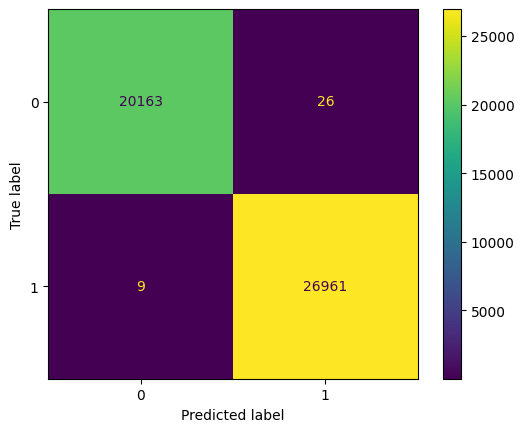

In [37]:
#Confusion matrix clean visual
cm_all = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_all)
disp.plot(values_format='d')

In [38]:
#Confidence ratings
y_prob = full_pipeline.predict_proba(X_test)[:, 1]


In [39]:
y_prob

array([1.        , 0.99999995, 0.99999957, ..., 1.        , 1.        ,
       0.99974943])

In [40]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


In [41]:
# Get coefficients out of model
model = full_pipeline.named_steps['model']
print(model.coef_)  # Sparse but interpretable

[[-1.71818186e-01  2.06320232e+00 -4.39929772e-01 ... -9.99690616e-03
  -1.41402021e-04 -1.18969261e-02]]


In [42]:
#Grab the preprocessor
preprocessor = full_pipeline.named_steps['prep']

# FEature names
cat_features = preprocessor.named_transformers_['cat'].named_steps['encode'].get_feature_names_out(['TLD'])
text_features = preprocessor.named_transformers_['text'].named_steps['tfidf'].get_feature_names_out()

# Combine column names
feature_names = (
    preprocessor.transformers_[0][2] +  # pure_numeric_cols
    preprocessor.transformers_[1][2] +  # bool_like_cols
    cat_features.tolist() +
    text_features.tolist()
)


In [43]:
#Get coefficients
model = full_pipeline.named_steps['model']
coefficients = model.coef_[0]  # For binary classification

#Combine coefficients with column/feature names
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)




In [44]:
# view
print(feature_importance.head(20))  # Most phishing-indicative
print(feature_importance.tail(20))  # Most benign-indicative

              Feature  Coefficient
29            IsHTTPS    11.012409
22        NoOfSelfRef     6.149079
19          NoOfImage     5.830653
21             NoOfJS     5.358606
24    NoOfExternalRef     5.190112
16         LineOfCode     4.395199
34       HasSocialNet     3.595072
38   HasCopyrightInfo     2.619871
30           HasTitle     2.450071
1        DomainLength     2.063202
521           TLD_org     1.910880
662            TLD_uk     1.472139
18         NoOfiFrame     1.441654
280            TLD_de     1.417984
20            NoOfCSS     1.303791
23       NoOfEmptyRef     1.227769
4       NoOfSubDomain     1.002983
258           TLD_com     0.876148
36    HasHiddenFields     0.660707
407            TLD_jp     0.522231
                        Feature  Coefficient
284                     TLD_dev    -0.408894
2            URLSimilarityIndex    -0.439930
333                      TLD_ga    -0.485527
238                      TLD_cf    -0.519054
396                      TLD_io    -0.56

In [45]:
# Logistic regression with PCA 90%
pipeline_90 = Pipeline([
    ('prep', preprocessor_90),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])



In [46]:
# Fit model and predict
pipeline_90.fit(X_train, y_train)
y_90_pred = pipeline_90.predict(X_test)

In [47]:
print(confusion_matrix(y_test, y_90_pred))
print(classification_report(y_test, y_90_pred))

[[20161    28]
 [   13 26957]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



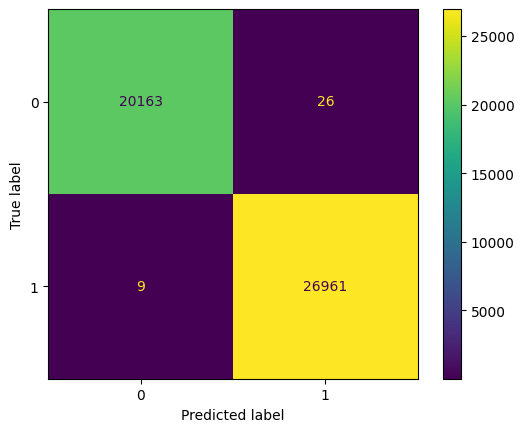

In [48]:
cm_90 = confusion_matrix(y_test, y_90_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_all)
disp.plot(values_format='d')

## Random Forest

In [49]:
# Random Forest model with No PCA
pipeline_rf_all = Pipeline([
    ('prep', preprocessor_all),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_rf_all.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function squeeze_column at 0xff6c42df07c0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [50]:
# Predictions
rf_pred_all = pipeline_rf_all.predict(X_test)


In [51]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, rf_pred_all))
print(classification_report(y_test, rf_pred_all))

[[20184     5]
 [    1 26969]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



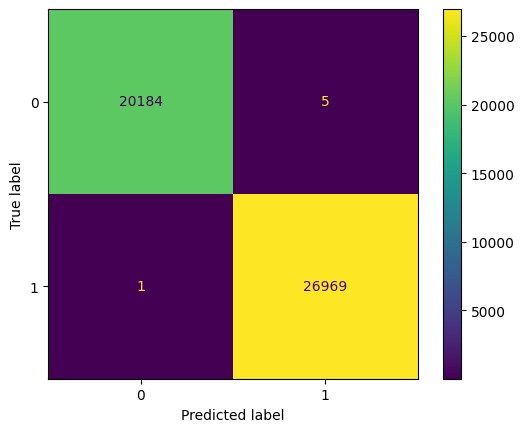

In [52]:
# Confusion matrix clean
rf_cm_all = confusion_matrix(y_test, rf_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_all)
disp.plot(values_format='d')

## XGBoost

In [53]:
# XGBoost classifier with no PCA
pipeline_xgb_all = Pipeline([
    ('prep', preprocessor_all),
    ('model', XGBClassifier(random_state=42))
])

pipeline_xgb_all.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [54]:
# Predict
xgb_pred_all = pipeline_xgb_all.predict(X_test)

In [55]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, xgb_pred_all))
print(classification_report(y_test, xgb_pred_all))

[[20187     2]
 [    0 26970]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



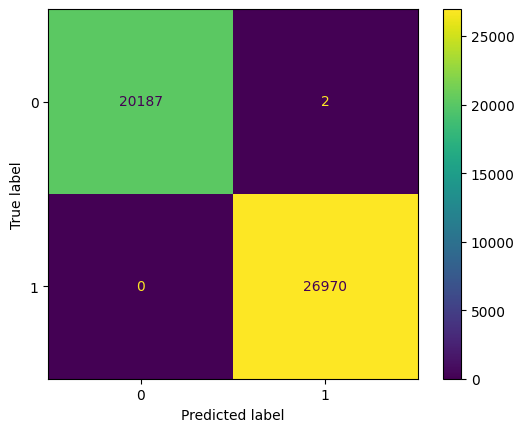

In [56]:
# Confusion matrix clean display
xgb_cm_all = confusion_matrix(y_test, xgb_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm_all)
disp.plot(values_format='d')

## KNN

In [57]:
# K Neighbor Classifier with no PCA
pipeline_knn_all = Pipeline([
    ('prep', preprocessor_all),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

pipeline_knn_all.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function squeeze_column at 0xff6c42df07c0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', KNeighborsClassifier())])

In [58]:
# Predictions
knn_pred_all = pipeline_knn_all.predict(X_test)

In [59]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, knn_pred_all))
print(classification_report(y_test, knn_pred_all))

[[20138    51]
 [   45 26925]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



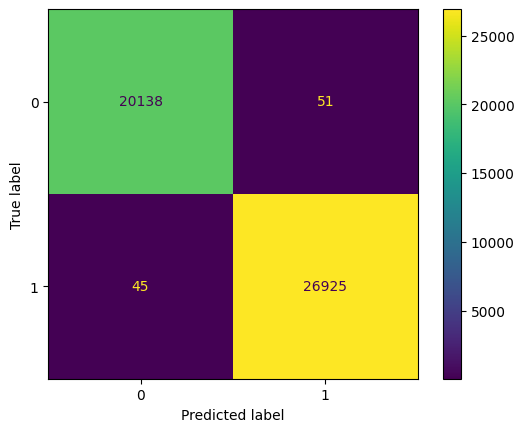

In [60]:
# confusion matrix review
knn_cm_all = confusion_matrix(y_test, knn_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm_all)
disp.plot(values_format='d')

## Neural Network

In [61]:
# Modeling with a neural network - transforming X_train columns
X_train_transformed = preprocessor_all.fit_transform(X_train)
X_test_transformed = preprocessor_all.transform(X_test)

In [62]:
# convert to array
if scipy.sparse.issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()
    X_test_transformed = X_test_transformed.toarray()

In [63]:
# Create dense multi layered model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_transformed.shape[1]))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [66]:
# Fit the model
model.fit(
    X_train_transformed, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9920 - loss: 0.0257 - val_accuracy: 0.9997 - val_loss: 0.0013
Epoch 2/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9998 - val_loss: 8.2534e-04
Epoch 3/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9996 - val_loss: 9.1384e-04
Epoch 4/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 7.1242e-04
Epoch 5/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9998 - val_loss: 7.5558e-04
Epoch 6/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9995 - val_loss: 0.0012
Epoch 7/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9998 - val_loss: 5.3335e-04
Epoch 8/20
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accura

In [67]:
# Predict probabilities
model.predict(X_test_transformed)

1474/1474 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step 


array([[0.99999976],
       [1.        ],
       [1.        ],
       ...,
       [1.        ],
       [1.        ],
       [0.9999624 ]], dtype=float32)

In [68]:
# After further testing, this model wasn't working as good as the others - not sure where the tests went, but decided to go ahead and test the other models on raw URL data to see how it performs

## Testing Model on Raw URL's

In [69]:
# Load in a new dataset that has URL's and phishing labels
test_df = pd.read_csv("Data/url_dataset.csv")

In [70]:
# change column type values to numeric to align with phish_df
test_df['type'] = test_df['type'].map({'legitimate': 1, 'phishing': 0})

In [71]:
# View top 5 rows
test_df.head()

url  type
0     https://www.google.com     1
1    https://www.youtube.com     1
2   https://www.facebook.com     1
3      https://www.baidu.com     1
4  https://www.wikipedia.org     1

In [72]:
# Rename type column to label to align with phish_df
test_df.rename(columns={'type': 'label'}, inplace=True)

In [73]:
test_df.head()

url  label
0     https://www.google.com      1
1    https://www.youtube.com      1
2   https://www.facebook.com      1
3      https://www.baidu.com      1
4  https://www.wikipedia.org      1

In [74]:
# Get all labels with value 1 - legitimate
test_df_leg = test_df[test_df['label'] == 1]

In [75]:
len(test_df_leg)

345738

In [76]:
# Get all values with label 0 - phishing
test_df_phi = test_df[test_df['label'] == 0]

In [77]:
len(test_df_phi)

104438

In [78]:
# Create testing DF of 100 values of each
test_df_100 = pd.concat([test_df_leg.head(50), test_df_phi.head(50)])


# Used Later - Created new DF for getting 1000 total URL's from new dataset
test_df_1000 = pd.concat([test_df_leg.head(500), test_df_phi.head(500)])

In [79]:
# View DF
test_df_100.head(100)

url  label
0                                  https://www.google.com      1
1                                 https://www.youtube.com      1
2                                https://www.facebook.com      1
3                                   https://www.baidu.com      1
4                               https://www.wikipedia.org      1
...                                                   ...    ...
345783                      https://sercure-pagealert.cf/      0
345784  http://rejennaration.org/secure/online%20verif...      0
345785  http://smokesonstate.com/Gssss/Gssss/470a461a3...      0
345786     http://zonasegurabcpenlinea.mospacepe.com/bcp/      0
345787  http://signin.resolution-center-account.com/we...      0

[100 rows x 2 columns]

## Cell below will take about 10 minutes to run
## Larger dataset created later and saved in 10k_URL_Training.csv - but if you want to run any code that calls the Phishing Features Class - this is the smallest one

In [ ]:
# Call phishing_features_class to extract values - tqdm to monitor progress
features_list = []

for _, row in tqdm(test_df_100.iterrows(), desc="Getting Phishing Features"):
    try:
        extractor = PhishingFeatureExtractor(row['url'])  #Create instance of class
        features = extractor.to_dict() # Get features in a dictionary
        features['label'] = row['label'] #Add label
        features['URL'] = row['url'] # Add URL
        features_list.append(features)
    except Exception as e:
        print("Skipped due to parsing error")
        continue

        
# Save as a dataframe
features_df = pd.DataFrame(features_list)

Getting Phishing Features: 30it [00:43,  1.52s/it]

Request failed: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6cd7288890>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6cd7293750>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://www.list.tmall.com: HTTPSConnectionPool(host='www.list.tmall.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6cd7293850>: Failed to resolve 'www.list.tmall.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 34it [00:45,  1.56it/s]

Request failed: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Redirect check failed: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))
Error checking self redirects for https://www.t.co: HTTPSConnectionPool(host='www.t.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: SSLV3_ALERT_HANDSHAKE_FAILURE] sslv3 alert handshake failure (_ssl.c:1006)')))


Getting Phishing Features: 50it [01:02,  1.18it/s]

Request failed: HTTPConnectionPool(host='atualizacaodedados.online', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b059717d0>: Failed to resolve 'atualizacaodedados.online' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='atualizacaodedados.online', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05811bd0>: Failed to resolve 'atualizacaodedados.online' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://atualizacaodedados.online: HTTPConnectionPool(host='atualizacaodedados.online', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05814fd0>: Failed to resolve 'atualizacaodedados.online' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 52it [01:03,  1.19it/s]

Request failed: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05817750>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05813510>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://stcdxmt.bigperl.in/klxtv/apps/uk/: HTTPConnectionPool(host='stcdxmt.bigperl.in', port=80): Max retries exceeded with url: /klxtv/apps/uk/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05811550>: Failed to resolve 'stcdxmt.bigperl.in' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='tubuh-sya

Getting Phishing Features: 54it [01:19,  3.54s/it]

Error checking self redirects for https://tubuh-syarikat.com/plugins/fields/files/: HTTPSConnectionPool(host='tubuh-syarikat.com', port=443): Max retries exceeded with url: /plugins/fields/files/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0xff6b05804210>, 'Connection to tubuh-syarikat.com timed out. (connect timeout=5)'))


Getting Phishing Features: 55it [01:20,  2.97s/it]

Request failed: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05811590>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05817290>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 56it [01:35,  5.89s/it]

Error checking self redirects for http://ongelezen-voda.000webhostapp.com/inloggen.html: HTTPConnectionPool(host='ongelezen-voda.000webhostapp.com', port=80): Max retries exceeded with url: /inloggen.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05805ed0>: Failed to resolve 'ongelezen-voda.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 60it [01:41,  2.84s/it]

Request failed: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b057f7b10>: Failed to resolve 'membership-issue.forteimpex.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05806950>: Failed to resolve 'membership-issue.forteimpex.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://membership-issue.forteimpex.com/dk2mmm=/?resType=code&amp;failedBe=: HTTPConnectionPool(host='membership-issue.forteimpex.com', port=80): Max retries exceeded with url: /dk2mmm=/?resType=code&amp;failedBe= (Caused by NameResolutionError("<urllib3.connection.HTTPConnecti

Getting Phishing Features: 68it [01:45,  1.06s/it]

Request failed: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b057f58d0>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05938050>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://www.tevhidigundem.ml/login/: HTTPConnectionPool(host='www.tevhidigundem.ml', port=80): Max retries exceeded with url: /login/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05939510>: Failed to resolve 'www.tevhidigundem.ml' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='cancel.direct.page-scure124

Getting Phishing Features: 70it [02:09,  4.61s/it]

Error checking self redirects for http://upperhouse.000webhostapp.com/ksovo/index.php: HTTPConnectionPool(host='upperhouse.000webhostapp.com', port=80): Max retries exceeded with url: /ksovo/index.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b0596be90>: Failed to resolve 'upperhouse.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='kungaguesthouse.com', port=80): Max retries exceeded with url: /wp-admin/english/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff6b0593b250>, 'Connection to kungaguesthouse.com timed out. (connect timeout=5)'))
Redirect check failed: HTTPConnectionPool(host='kungaguesthouse.com', port=80): Max retries exceeded with url: /wp-admin/english/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff6b0593b150>, 'Connection to kungaguesthouse.com timed out. (connect timeout=5)'))


Getting Phishing Features: 71it [02:23,  6.39s/it]

Error checking self redirects for http://kungaguesthouse.com/wp-admin/english/: HTTPConnectionPool(host='kungaguesthouse.com', port=80): Max retries exceeded with url: /wp-admin/english/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0xff6b05923550>, 'Connection to kungaguesthouse.com timed out. (connect timeout=5)'))


Getting Phishing Features: 73it [02:25,  4.09s/it]

Request failed: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b059232d0>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b059207d0>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://hostcpanelverfyonline.16mb.com/micav.php: HTTPConnectionPool(host='hostcpanelverfyonline.16mb.com', port=80): Max retries exceeded with url: /micav.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05939c10>: Failed to resolve 'hostcpanelverfyonline.16mb.com' ([Errno -2] Name or service n

Getting Phishing Features: 74it [02:41,  7.25s/it]

Error checking self redirects for https://rexlbox.000webhostapp.com/docs/secure/verification.html: HTTPSConnectionPool(host='rexlbox.000webhostapp.com', port=443): Max retries exceeded with url: /docs/secure/verification.html (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6b05ae8390>: Failed to resolve 'rexlbox.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPSConnectionPool(host='secure000-webpaypal.com', port=443): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6b059206d0>: Failed to resolve 'secure000-webpaypal.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='secure000-webpaypal.com', port=443): Max retries exceeded with url: /signin/ (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6b0593b410>: Failed to resolve 'secure000-webpaypal.com' ([Errno -2] Name or servic

Getting Phishing Features: 76it [02:54,  6.77s/it]

Redirect check failed: HTTPConnectionPool(host='linkedln-contact.000webhostapp.com', port=80): Max retries exceeded with url: /login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05ae8ad0>: Failed to resolve 'linkedln-contact.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://linkedln-contact.000webhostapp.com/login.html: HTTPConnectionPool(host='linkedln-contact.000webhostapp.com', port=80): Max retries exceeded with url: /login.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05aeb050>: Failed to resolve 'linkedln-contact.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 77it [02:55,  5.62s/it]

Request failed: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b0596ac90>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b0593a150>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 78it [03:19, 10.00s/it]

Error checking self redirects for http://jhiulog-in0045.000webhostapp.com/xfinity/au/tes/ver/home/: HTTPConnectionPool(host='jhiulog-in0045.000webhostapp.com', port=80): Max retries exceeded with url: /xfinity/au/tes/ver/home/ (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b0593a410>: Failed to resolve 'jhiulog-in0045.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05920290>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05aead10>: Failed to resolve '

Getting Phishing Features: 79it [03:48, 14.91s/it]

Error checking self redirects for http://securityceckpoins.000webhostapp.com/bayar/set.html: HTTPConnectionPool(host='securityceckpoins.000webhostapp.com', port=80): Max retries exceeded with url: /bayar/set.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6cd7b3e290>: Failed to resolve 'securityceckpoins.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b058233d0>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -3] Temporary failure in name resolution)"))
Redirect check failed: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05aeb810>: Fa

Getting Phishing Features: 80it [04:13, 17.66s/it]

Error checking self redirects for http://member-unblock.000webhostapp.com/Unblock/inet-update-01.html: HTTPConnectionPool(host='member-unblock.000webhostapp.com', port=80): Max retries exceeded with url: /Unblock/inet-update-01.html (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05939010>: Failed to resolve 'member-unblock.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05969810>: Failed to resolve 'donefe.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 81it [04:27, 16.65s/it]

Redirect check failed: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6cd7b09f90>: Failed to resolve 'donefe.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for http://donefe.000webhostapp.com/auto/auto%20ferify/mail.php: HTTPConnectionPool(host='donefe.000webhostapp.com', port=80): Max retries exceeded with url: /auto/auto%20ferify/mail.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b057f95d0>: Failed to resolve 'donefe.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='drcharys.com', port=80): Max retries exceeded with url: /admin/js/regain/login.php?cmd=login_submit&id=4f796368ffdd2b0a79f3c7ba91368e824f796368ffdd2b0a79f3c7ba91368e82&session=4f796368ffdd2b0a79f3c7ba91368e824f796368ffdd2b0a79f3c7ba913

Getting Phishing Features: 85it [04:30,  5.79s/it]

Request failed: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6b05939850>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -2] Name or service not known)"))


Getting Phishing Features: 86it [04:41,  7.35s/it]

Redirect check failed: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6b057f9ed0>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://egamandala0031.000webhostapp.com/bayar/VisaPayments.html?fb_source=bookmark_apps: HTTPSConnectionPool(host='egamandala0031.000webhostapp.com', port=443): Max retries exceeded with url: /bayar/VisaPayments.html?fb_source=bookmark_apps (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6b057fbc90>: Failed to resolve 'egamandala0031.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='dowf-cleat.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.

Getting Phishing Features: 87it [04:56,  9.33s/it]

Error checking self redirects for http://dowf-cleat.000webhostapp.com/Office365.php: HTTPConnectionPool(host='dowf-cleat.000webhostapp.com', port=80): Max retries exceeded with url: /Office365.php (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b0593af50>: Failed to resolve 'dowf-cleat.000webhostapp.com' ([Errno -2] Name or service not known)"))
Request failed: HTTPConnectionPool(host='www.yeezy-christmas.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b059399d0>: Failed to resolve 'www.yeezy-christmas.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPConnectionPool(host='www.yeezy-christmas.com', port=80): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0xff6b05970e90>: Failed to resolve 'www.yeezy-christmas.com' ([Errno -2] Name or service not known)"))
Error checking self redirects f

In [81]:
# View DF to make sure values are present
features_df.head()

NoOfJS  NoOfCSS  NoOfSelfRef  NoOfEmptyRef  NoOfExternalRef  IsResponsive  \
0       0        0           10             0                7             0   
1       9        5           13             0                2             0   
2       1        3           24             0               19             0   
3       0        1            3             0                8             0   
4       2        0            0             0              371             0   

   NoOfURLRedirect  NoOfSelfRedirect  NoOfImage  HasCopyrightInfo  ...  \
0                0                 0          1                 1  ...   
1                0                 0          0                 1  ...   
2                0                 0          2                 1  ...   
3                0                 0          2                 1  ...   
4                0                 0          1                 1  ...   

   URLSimilarityIndex  NoOfEqualsInURL  TLDLength  NoOfQMarkInURL  \
0                1.00                0          3               0   
1                0.73                0          3               0   
2                0.67                0          3               0   
3                0.78                0          3               0   
4                1.00                0          3               0   

   LetterRatioInURL  DegitRatioInURL  SpacialCharRatioInURL  \
0          0.772727              0.0               0.227273   
1          0.782609              0.0               0.217391   
2          0.791667              0.0               0.208333   
3          0.761905              0.0               0.238095   
4          0.800000              0.0               0.200000   

              Domain label                        URL  
0     www.google.com     1     https://www.google.com  
1    www.youtube.com     1    https://www.youtube.com  
2   www.facebook.com     1   https://www.facebook.com  
3      www.baidu.com     1      https://www.baidu.com  
4  www.wikipedia.org     1  https://www.wikipedia.org  

[5 rows x 44 columns]

In [82]:
# Create split for testing on previous created models
X_test_100 = features_df.drop(columns=['label'])
y_test_100 = features_df['label']



In [83]:
# View columns
features_df.columns

Index(['NoOfJS', 'NoOfCSS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef',
       'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'NoOfImage',
       'HasCopyrightInfo', 'HasPasswordField', 'HasHiddenFields',
       'HasSubmitButton', 'HasSocialNet', 'HasExternalFormSubmit',
       'NoOfiFrame', 'HasFavicon', 'HasTitle', 'Title', 'LineOfCode',
       'LargestLineLength', 'IsHTTPS', 'NoOfOtherSpecialCharsInURL',
       'NoOfAmpersandInURL', 'NoOfDegitsInURL', 'NoOfLettersInURL',
       'NoOfSubDomain', 'TLD', 'IsDomainIP', 'DomainLength', 'URLLength',
       'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio',
       'URLSimilarityIndex', 'NoOfEqualsInURL', 'TLDLength', 'NoOfQMarkInURL',
       'LetterRatioInURL', 'DegitRatioInURL', 'SpacialCharRatioInURL',
       'Domain', 'label', 'URL'],
      dtype='object')

In [84]:
# Make predictions using logistic pipeline with No PCA
y_pred_test = full_pipeline.predict(X_test_100)

In [85]:
# Calculate accuracy and classification report
accuracy = accuracy_score(y_test_100, y_pred_test)
report = classification_report(y_test_100, y_pred_test)

In [86]:
accuracy

0.52

In [87]:
# print classification report
print(report)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68        50
           1       1.00      0.04      0.08        50

    accuracy                           0.52       100
   macro avg       0.76      0.52      0.38       100
weighted avg       0.76      0.52      0.38       100



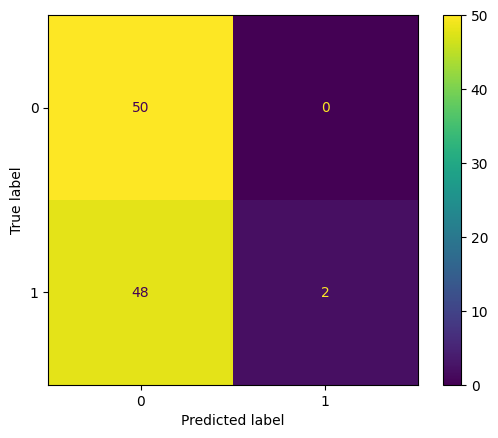

In [88]:
# Confusion matrix view - Almost all predictions are phishing - not good
cm = confusion_matrix(y_test_100, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [89]:
# testing data on random forest model - making predictions
rf_pred_test = pipeline_rf_all.predict(X_test_100)

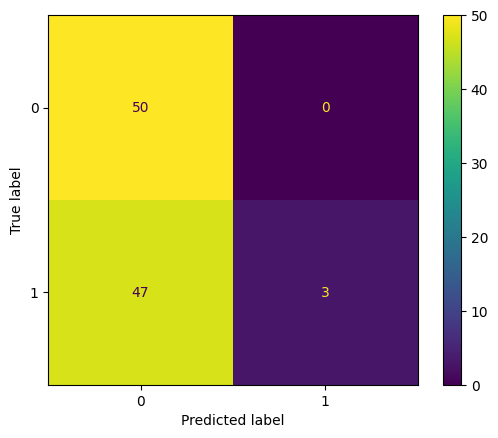

In [90]:
# Confusion matrix - better, but still bad
rf_cm_test = confusion_matrix(y_test_100, rf_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_test)
disp.plot()

In [91]:
# Testing on XGBoost model - making predictions
xgb_pred_test = pipeline_xgb_all.predict(X_test_100)

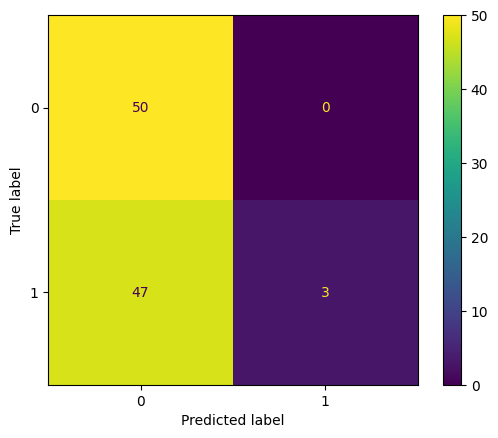

In [92]:
# Confusion matrix - better again, still not good
xgb_cm_test = confusion_matrix(y_test_100, xgb_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm_test)
disp.plot()

In [93]:
# Testing knn - making predictions
knn_pred_test = pipeline_knn_all.predict(X_test_100)

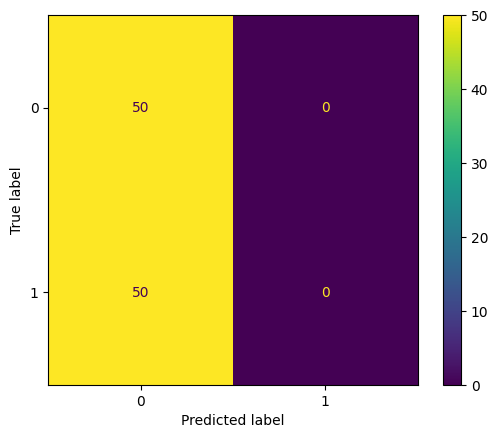

In [94]:
# Confusion matrix - all predictions are phishing, worst model yet.
knn_cm_test = confusion_matrix(y_test_100, knn_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm_test)
disp.plot()

In [95]:
# Testing on Neural network - transforming data
X_test_100_transfomred = preprocessor_all.transform(X_test_100)

In [96]:
# Making predictions
NN_pred_100_prob = model.predict(X_test_100_transfomred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [97]:
# Getting highest prediction
NN_pred_100 = (NN_pred_100_prob > 0.5).astype(int)

In [98]:
# Confusion matrix, classification report, roc auc - all not good
print(confusion_matrix(y_test_100, NN_pred_100))
print(classification_report(y_test_100, NN_pred_100))
print("ROC AUC:", roc_auc_score(y_test_100, NN_pred_100_prob))


[[50  0]
 [48  2]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        50
           1       1.00      0.04      0.08        50

    accuracy                           0.52       100
   macro avg       0.76      0.52      0.38       100
weighted avg       0.76      0.52      0.38       100

ROC AUC: 0.5700000000000001


In [99]:
#xgb_pred_test_1000 = pipeline_xgb_all.predict(X_test_1000)

## Reverse modeling - modeling on datset of URL's with labels and gets info from phishing features class
## Tests on original UCI dataset

## Data loaded was pre-captured using phishing_Features_Class.py

In [100]:
# Run this cell which which contains 3000 URL's from 2nd dataset
features_df = pd.read_csv("Data/phishing_features_2000.csv")

In [101]:
# Retesting the XGBoost model as it was the best performer
# Creating new DF for testing
X_test_1000 = features_df.drop(columns=['label'])
y_test_1000 = features_df['label']

# Make predictions
xgb_pred_test_1000 = pipeline_xgb_all.predict(X_test_1000)

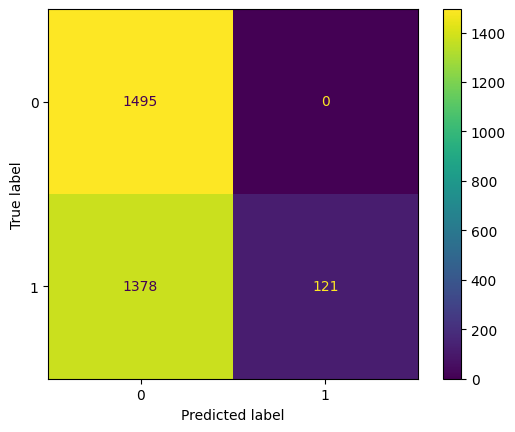

In [102]:
# Confusion Matrix - Still not good.  Mostly phishing
xgb_cm_test_1000 = confusion_matrix(y_test_1000, xgb_pred_test_1000)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm_test_1000)
disp.plot()

In [103]:
# Fitting new dataset to XGB pipeline to see performance
pipeline_xgb_all.fit(X_test_1000, y_test_1000)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [104]:
# Make predicitons on original split data from original dataset
pred_y = pipeline_xgb_all.predict(X_test)

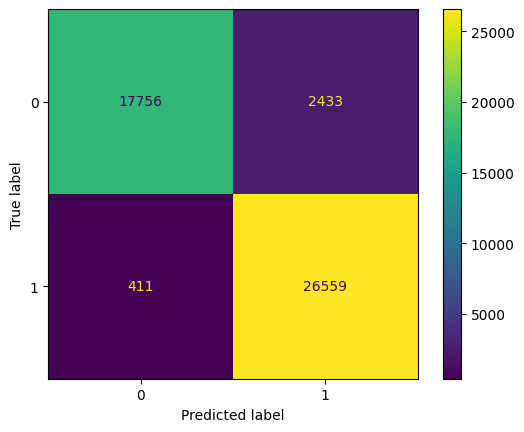

In [105]:
# Confusion matrix on dataset after modeling based on new dataset - much better performance
rev_xgb_cm_test_1000 = confusion_matrix(y_test, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=rev_xgb_cm_test_1000)
disp.plot()

## Creating New Dataset for Training after Testing Failed - Combo of 2 different datasets

In [106]:
# from url_dataset - get 2000 rows, 1000 legitimate, 1000 phishing
stratified_2000 = test_df.groupby('label', group_keys=False).sample(n=1000, random_state=42)

In [107]:
len(stratified_2000)

2000

## Data loaded was pre-captured using phishing_Features_Class.py

In [109]:
# Load data created by cell above
features_df_2000 = pd.read_csv("Data/phishing_features_2000.csv")

In [110]:
# Get data from original UCI dataset with dropping columns that the phishing features df does not calculate
New_CSV_File_original = phish_df.drop(['CharContinuationRate', 'NoOfPopup', 'FILENAME', 'TLDLegitimateProb', 'URLCharProb', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'Robots', 'HasDescription', 'Bank', 'Pay', 'Crypto'], axis=1)

In [111]:
# Check length of column
New_CSV_File_original.columns

Index(['URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD',
       'URLSimilarityIndex', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation',
       'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL',
       'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL',
       'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
       'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS',
       'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title', 'HasFavicon',
       'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'NoOfiFrame',
       'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton',
       'HasHiddenFields', 'HasPasswordField', 'HasCopyrightInfo', 'NoOfImage',
       'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef',
       'label'],
      dtype='object')

In [112]:
# Check length of column - 
len(features_df_2000.columns)

44

In [113]:
# Check head of 2000 URL's with featuresfeatures_df_2000.head()

NoOfJS  NoOfCSS  NoOfSelfRef  NoOfEmptyRef  NoOfExternalRef  IsResponsive  \
0       0        0           10             0                7             0   
1       9        5           13             0                2             0   
2       1        3           24             0               19             0   
3       0        1            3             0                8             0   
4       2        0            0             0              371             0   

   NoOfURLRedirect  NoOfSelfRedirect  NoOfImage  HasCopyrightInfo  ...  \
0                0                 0          1                 1  ...   
1                0                 0          0                 1  ...   
2                0                 0          2                 1  ...   
3                0                 0          2                 1  ...   
4                0                 0          1                 1  ...   

   URLSimilarityIndex  NoOfEqualsInURL  TLDLength  NoOfQMarkInURL  \
0                1.00                0          3               0   
1                0.73                0          3               0   
2                0.67                0          3               0   
3                0.78                0          3               0   
4                1.00                0          3               0   

   LetterRatioInURL  DegitRatioInURL  SpacialCharRatioInURL  label  \
0          0.772727              0.0               0.227273      1   
1          0.782609              0.0               0.217391      1   
2          0.791667              0.0               0.208333      1   
3          0.761905              0.0               0.238095      1   
4          0.800000              0.0               0.200000      1   

                         URL             Domain  
0     https://www.google.com     www.google.com  
1    https://www.youtube.com    www.youtube.com  
2   https://www.facebook.com   www.facebook.com  
3      https://www.baidu.com      www.baidu.com  
4  https://www.wikipedia.org  www.wikipedia.org  

[5 rows x 44 columns]

In [116]:
# Get columns to see the 1 difference
cols_orig = New_CSV_File_original.columns
cols_new = features_df_2000.columns

In [117]:
# Difference is 'Domain' - realized it wasn't in extract_all in phishing features class
diff = list( set(cols_orig) - set(cols_new))

In [118]:
diff

[]

In [119]:
len(cols_orig)

44

In [120]:
# Manually get the Domain value from the phishing features class
for idx, row in tqdm(features_df_2000.iterrows(), total=len(features_df_2000), desc="Get Domain"):
    extractor = PhishingFeatureExtractor(row['URL'], fetch_soup=False)
    features_df_2000.at[idx, 'Domain'] = extractor.extract_domain()


    

Get Domain: 100%|██████████| 2994/2994 [00:00<00:00, 33957.29it/s]


In [121]:
# Number of columns
len(features_df_2000.columns)

44

In [122]:
# Saving as file - 2000 took about 1.5 hours to run before
features_df_2000.to_csv("Data/phishing_features_2000.csv", index=False)

In [123]:
# Get 3000 values from the original UCI dataset to concatenate with newly created dataset features_df_2000
original_stratify_3000 = New_CSV_File_original.groupby('label', group_keys=False).sample(n=1500, random_state=42)

In [124]:
# Concatenate the two dataframes
model_df = pd.concat([features_df_2000, original_stratify_3000], ignore_index=True)

In [125]:
# Verify DF size
len(model_df)

5994

In [126]:
# Remodeling with new dataset of 5994 values
X1 = model_df.drop(columns=['label'])
y1 = model_df['label']

# Split the dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)

X1_train.shape, y1_train.shape, X1_test.shape, y1_test.shape

((4795, 43), (4795,), (1199, 43), (1199,))

In [127]:
# using XGBoost Classifier and no PCA
xgb_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', XGBClassifier(random_state=42))
])

xgb_pipeline.fit(X1_train, y1_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [128]:
# Make predictions
y1_pred_xgb = xgb_pipeline.predict(X1_test)



In [129]:
# Confusion matrix and classification report
print(confusion_matrix(y1_test, y1_pred_xgb))
print(classification_report(y1_test, y1_pred_xgb))


[[585  14]
 [  3 597]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       599
           1       0.98      0.99      0.99       600

    accuracy                           0.99      1199
   macro avg       0.99      0.99      0.99      1199
weighted avg       0.99      0.99      0.99      1199



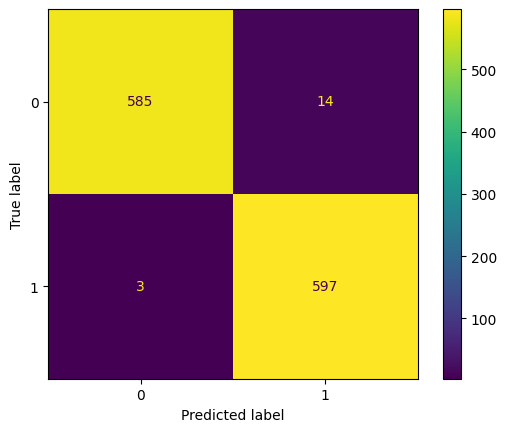

In [130]:
# Confusion matrix clean display
xgb_y1_cm_all = confusion_matrix(y1_test, y1_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_y1_cm_all)
disp.plot(values_format='d')

In [131]:
# Making dataset bigger - getting additional 1000 phishing urls
label_0_df = test_df[test_df['label'] == 0]
label_0_not_in_model = label_0_df[~label_0_df['url'].isin(model_df['URL'])] # Make sure they are new URL's
sampled_1000_0 = label_0_not_in_model.sample(n=1000, random_state=42)

In [132]:
# Making dataset bigger - getting additional 1000 legitimate urls
label_1_df = test_df[test_df['label'] == 1]
label_1_not_in_model = label_1_df[~label_1_df['url'].isin(model_df['URL'])] # Make sure they are new URL's
sampled_1000_1 = label_1_not_in_model.sample(n=1000, random_state=42)

In [133]:
# Concatenate into one DF
new_sample = pd.concat([sampled_1000_0, sampled_1000_1], ignore_index=True)

## Modeling New Dataset

In [135]:
df = pd.read_csv("Data/10k_URL_Training.csv")

In [136]:
df.head()

Unnamed: 0  NoOfJS  NoOfCSS  NoOfSelfRef  NoOfEmptyRef  NoOfExternalRef  \
0           0       3        5           22             1               14   
1           1       4        0            5             2                3   
2           2       0        0            0             0                0   
3           3       0        0            2             0                4   
4           4       0        0            0             0                0   

   IsResponsive  NoOfURLRedirect  NoOfSelfRedirect  NoOfImage  ...  \
0             1                0                 0          5  ...   
1             1                1                 1          1  ...   
2             0                0                 0          0  ...   
3             1                3                 1          1  ...   
4             0                0                 0          0  ...   

   URLSimilarityIndex  NoOfEqualsInURL  TLDLength  NoOfQMarkInURL  \
0                0.67                0          3               0   
1                0.57                0          4               0   
2                0.75                0          3               0   
3                1.00                0          3               0   
4                0.40                0          2               0   

   LetterRatioInURL  DegitRatioInURL  SpacialCharRatioInURL  label  \
0          0.866667         0.000000               0.133333      0   
1          0.750000         0.000000               0.250000      0   
2          0.827957         0.032258               0.139785      0   
3          0.764706         0.078431               0.156863      0   
4          0.782609         0.028986               0.188406      0   

                                                 URL  \
0      https://eansidsaninasdniasndini.blogspot.com/   
1                               http://adbreak.info/   
2  http://screwstudprediche.02tablet.com/0qfgsypx...   
3  https://sites.google.com/site/updatesystem2018...   
4  http://ogloszenia.wpr24.pl/elrte/src/elrte/ima...   

                                 Domain  
0  eansidsaninasdniasndini.blogspot.com  
1                          adbreak.info  
2        screwstudprediche.02tablet.com  
3                      sites.google.com  
4                   ogloszenia.wpr24.pl  

[5 rows x 45 columns]

In [137]:
len(df)

9994

## Train Test Split

In [138]:
X2 = df.drop(columns=['label'])
y2 = df['label']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=42, stratify=y2)

## Logistic Classifier

In [139]:
log_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

log_pipeline.fit(X2_train, y2_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function squeeze_column at 0xff6c42df07c0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [140]:
y2_pred_log = log_pipeline.predict(X2_test)

In [141]:
# Confusion matrix and classification report
print(confusion_matrix(y2_test, y2_pred_log))
print(classification_report(y2_test, y2_pred_log))

[[966  33]
 [  7 993]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       999
           1       0.97      0.99      0.98      1000

    accuracy                           0.98      1999
   macro avg       0.98      0.98      0.98      1999
weighted avg       0.98      0.98      0.98      1999



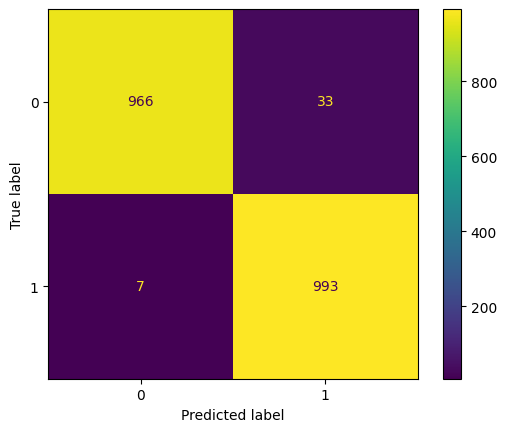

In [142]:
# Confusion matrix clean display
log_y2_cm_all = confusion_matrix(y2_test, y2_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=log_y2_cm_all)
disp.plot(values_format='d')

In [143]:
# Drop from UCI dataset, columns used for training
filtered_new_df = New_CSV_File_original[~New_CSV_File_original['URL'].isin(df['URL'])]

# split data for testing into seperate DF's
X_new = filtered_new_df.drop(columns=['label'])
y_new = filtered_new_df['label']

# Make predictions on 200k URL dataset from UCI
y2_new_pred_log = log_pipeline.predict(X_new)

In [144]:
# Confusion matrix and classification report
print(confusion_matrix(y_new, y2_new_pred_log))
print(classification_report(y_new, y2_new_pred_log))

[[ 96528   1893]
 [   670 131621]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     98421
           1       0.99      0.99      0.99    132291

    accuracy                           0.99    230712
   macro avg       0.99      0.99      0.99    230712
weighted avg       0.99      0.99      0.99    230712



## XGBoost

In [145]:
# using XGBoost Classifier and no PCA
xgb2_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', XGBClassifier(random_state=42))
])

xgb2_pipeline.fit(X2_train, y2_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [146]:
y2_pred_xgb = xgb2_pipeline.predict(X2_test)

In [147]:
# Confusion matrix and classification report
print(confusion_matrix(y2_test, y2_pred_xgb))
print(classification_report(y2_test, y2_pred_xgb))

[[985  14]
 [  4 996]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       999
           1       0.99      1.00      0.99      1000

    accuracy                           0.99      1999
   macro avg       0.99      0.99      0.99      1999
weighted avg       0.99      0.99      0.99      1999



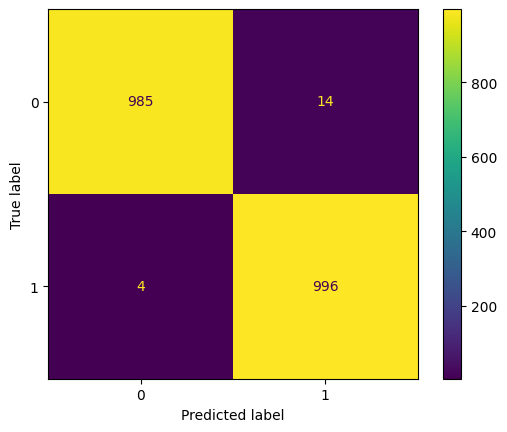

In [148]:
# Confusion matrix clean display
xgb_y2_cm_all = confusion_matrix(y2_test, y2_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_y2_cm_all)
disp.plot(values_format='d')

In [149]:
# Make predictions on 200k URL dataset from UCI
y2_new_pred = xgb2_pipeline.predict(X_new)

In [150]:
# Confusion matrix and classification report
print(confusion_matrix(y_new, y2_new_pred))
print(classification_report(y_new, y2_new_pred))

[[ 98151    270]
 [    38 132253]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98421
           1       1.00      1.00      1.00    132291

    accuracy                           1.00    230712
   macro avg       1.00      1.00      1.00    230712
weighted avg       1.00      1.00      1.00    230712



## Random Forest

In [151]:
# using Random Forest Classifier and no PCA
rf2_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', RandomForestClassifier(random_state=42))
])

rf2_pipeline.fit(X2_train, y2_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function squeeze_column at 0xff6c42df07c0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [152]:
y2_pred_rf = rf2_pipeline.predict(X2_test)

In [153]:
# Confusion matrix and classification report
print(confusion_matrix(y2_test, y2_pred_rf))
print(classification_report(y2_test, y2_pred_rf))

[[985  14]
 [  4 996]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       999
           1       0.99      1.00      0.99      1000

    accuracy                           0.99      1999
   macro avg       0.99      0.99      0.99      1999
weighted avg       0.99      0.99      0.99      1999



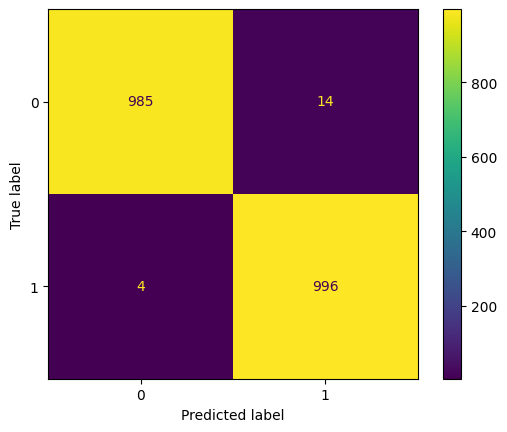

In [154]:
# Confusion matrix clean display
rf_y2_cm_all = confusion_matrix(y2_test, y2_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=rf_y2_cm_all)
disp.plot(values_format='d')

In [155]:
# Make predictions on 200k URL dataset from UCI
y2_new_pred_rf = rf2_pipeline.predict(X_new)

In [156]:
# Confusion matrix and classification report
print(confusion_matrix(y_new, y2_new_pred_rf))
print(classification_report(y_new, y2_new_pred_rf))

[[ 98168    253]
 [    36 132255]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98421
           1       1.00      1.00      1.00    132291

    accuracy                           1.00    230712
   macro avg       1.00      1.00      1.00    230712
weighted avg       1.00      1.00      1.00    230712



## KNN

In [157]:
knn2_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

knn2_pipeline.fit(X2_train, y2_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['URLLength', 'DomainLength',
                                                   'URLSimilarityIndex',
                                                   'TLDLength', 'NoOfSubDomain',
                                                   'NoOfObfuscatedChar',
                                                   'ObfuscationRatio',
                                                   'NoOfLettersInURL',
                                                   'LetterRatioInURL',
                                                   'NoOfDegitsInURL',
                                                   'DegitRatioInURL',
                                                   'NoOf...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['TLD']),
                                                 ('text',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='',
                                                                                 strategy='constant')),
                                                                  ('reshape',
                                                                   FunctionTransformer(func=<function squeeze_column at 0xff6c42df07c0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=500))]),
                                                  ['Title'])])),
                ('model', KNeighborsClassifier())])

In [158]:
# Predictions
y2_pred_knn = knn2_pipeline.predict(X2_test)

In [159]:
# Confusion matrix and classification report
print(confusion_matrix(y2_test, y2_pred_knn))
print(classification_report(y2_test, y2_pred_knn))

[[953  46]
 [ 14 986]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       999
           1       0.96      0.99      0.97      1000

    accuracy                           0.97      1999
   macro avg       0.97      0.97      0.97      1999
weighted avg       0.97      0.97      0.97      1999



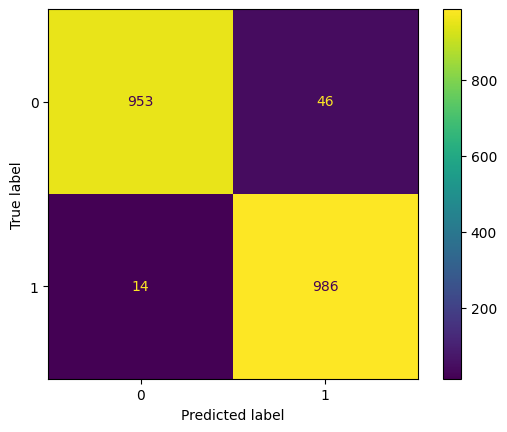

In [160]:
# Confusion matrix clean display
knn_y2_cm_all = confusion_matrix(y2_test, y2_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_y2_cm_all)
disp.plot(values_format='d')

In [161]:
# Make predictions on 200k URL dataset from UCI
y2_new_pred_knn = knn2_pipeline.predict(X_new)

In [162]:
# Confusion matrix and classification report
print(confusion_matrix(y_new, y2_new_pred_knn))
print(classification_report(y_new, y2_new_pred_knn))

[[ 97773    648]
 [   947 131344]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     98421
           1       1.00      0.99      0.99    132291

    accuracy                           0.99    230712
   macro avg       0.99      0.99      0.99    230712
weighted avg       0.99      0.99      0.99    230712



## Neural Network

In [163]:
# Modeling with a neural network - transforming X_train columns
X2_train_transformed = preprocessor_all.fit_transform(X2_train)
X2_test_transformed = preprocessor_all.transform(X2_test)

X2_train_transformed.shape, X2_test_transformed.shape, y2_train.shape

((7995, 839), (1999, 839), (7995,))

In [164]:
# convert to array
if scipy.sparse.issparse(X2_train_transformed):
    X2_train_transformed = X2_train_transformed.toarray()
    X2_test_transformed = X2_test_transformed.toarray()

In [165]:
# Create dense multi layered model
model2 = Sequential()
model2.add(Dense(128, activation='relu', input_dim=X2_train_transformed.shape[1]))
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
# Implement early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model
model2.fit(
    X2_train_transformed, y2_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8727 - loss: 0.3203 - val_accuracy: 0.9825 - val_loss: 0.0577
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9857 - loss: 0.0514 - val_accuracy: 0.9887 - val_loss: 0.0443
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0402 - val_accuracy: 0.9837 - val_loss: 0.0471
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9878 - loss: 0.0376 - val_accuracy: 0.9887 - val_loss: 0.0418
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9898 - loss: 0.0325 - val_accuracy: 0.9825 - val_loss: 0.0438
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9904 - loss: 0.0313 - val_accuracy: 0.9900 - val_loss: 0.0421
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0326 - val_accuracy: 0.9875 - val_loss: 0.0408
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9902 - loss: 0.0303 - val_accuracy: 0.

In [167]:
# Predict probabilities
y2_pred_NN_prob = model2.predict(X2_test_transformed)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [168]:
y2_pred_NN = (y2_pred_NN_prob > 0.5).astype(int)

In [169]:
# Confusion matrix, classification report, roc auc - all not good
print(confusion_matrix(y2_test, y2_pred_NN))
print(classification_report(y2_test, y2_pred_NN))
print("ROC AUC:", roc_auc_score(y2_test, y2_pred_NN_prob))


[[979  20]
 [  6 994]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       999
           1       0.98      0.99      0.99      1000

    accuracy                           0.99      1999
   macro avg       0.99      0.99      0.99      1999
weighted avg       0.99      0.99      0.99      1999

ROC AUC: 0.9981286286286286


In [170]:
X_new_transformed = preprocessor_all.transform(X_new)
y2_new_pred_NN_prob = model2.predict(X_new_transformed)

7210/7210 ━━━━━━━━━━━━━━━━━━━━ 7s 930us/step


In [171]:
y2_new_pred_NN = (y2_new_pred_NN_prob > 0.5).astype(int)

## Comparing metrics for XGBoost and Random Forest and Neural Networks

In [172]:
# Metrics for XGBoost model
xgb_accuracy = accuracy_score(y_new, y2_new_pred) 
xgb_precision = precision_score(y_new, y2_new_pred) 
xgb_recall = recall_score(y_new, y2_new_pred) 
xgb_f1 = f1_score(y_new, y2_new_pred) 
xgb_roc_auc = roc_auc_score(y_new, y2_new_pred) 

print(f"XGB Accuracy: {xgb_accuracy}")
print(f"XGB Precision: {xgb_precision}")
print(f"XGB Recall: {xgb_recall}")
print(f"XGB f1-score: {xgb_f1}")
print(f"XGB ROC AUC: {xgb_roc_auc}")

XGB Accuracy: 0.9986650022538923
XGB Precision: 0.9979626178097387
XGB Recall: 0.9997127544579753
XGB f1-score: 0.9988369194982138
XGB ROC AUC: 0.9984847187414698


In [173]:
# Metrics for RandomForest Model
rf_accuracy = accuracy_score(y_new, y2_new_pred_rf) 
rf_precision = precision_score(y_new, y2_new_pred_rf) 
rf_recall = recall_score(y_new, y2_new_pred_rf) 
rf_f1 = f1_score(y_new, y2_new_pred_rf) 
rf_roc_auc = roc_auc_score(y_new, y2_new_pred_rf) 

print(f"RF Accuracy: {rf_accuracy}")
print(f"RF Precision: {rf_precision}")
print(f"RF Recall: {rf_recall}")
print(f"RF f1-score: {rf_f1}")
print(f"RF ROC AUC: {rf_roc_auc}")

RF Accuracy: 0.9987473560109574
RF Precision: 0.9980906813173545
RF Recall: 0.9997278726443976
RF f1-score: 0.9989086061503254
RF ROC AUC: 0.9985786415172283


In [174]:
# Metrics for Neural Network
NN_accuracy = accuracy_score(y_new, y2_new_pred_NN) 
NN_precision = precision_score(y_new, y2_new_pred_NN) 
NN_recall = recall_score(y_new, y2_new_pred_NN) 
NN_f1 = f1_score(y_new, y2_new_pred_NN) 
NN_roc_auc = roc_auc_score(y_new, y2_new_pred_NN) 

print(f"NN Accuracy: {NN_accuracy}")
print(f"NN Precision: {NN_precision}")
print(f"NN Recall: {NN_recall}")
print(f"NN f1-score: {NN_f1}")
print(f"NN ROC AUC: {NN_roc_auc}")

NN Accuracy: 0.9980798571379035
NN Precision: 0.9974570260032296
NN Recall: 0.9991987361196151
NN f1-score: 0.9983271214026501
NN ROC AUC: 0.9978873350587203


## Random Forest worked the best - Grid Search for HyperParameters

In [175]:
gridsearch_pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', RandomForestClassifier(random_state=42))
])

precision_0_scoreer = make_scorer(precision_score, pos_label=0)

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=gridsearch_pipeline, param_grid=param_grid, cv=5, scoring=precision_0_scoreer, n_jobs=-1, verbose=2)
grid_search.fit(X2_train, y2_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['URLLength',
                                                                          'DomainLength',
                                                                          'URLSimilarityIndex',
                                                                          'TLDLength',
                                                                          'NoOfSubDomain',
                                                                          'NoOfObfuscatedChar',
                                                                          'ObfuscationRatio',
                                                                          'NoOfLettersInURL',
                                                                          'LetterRatioInURL',
                                                                          'NoOfDegitsIn...
                                                                                          TfidfVectorizer(max_features=500))]),
                                                                         ['Title'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring=make_scorer(precision_score, response_method='predict', pos_label=0),
             verbose=2)

In [176]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best score: 0.9949426697915567


In [177]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20189
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



## Random Search

In [178]:
# Pipeline for random search
pipeline = Pipeline([
    ('prep', preprocessor_all),
    ('model', RandomForestClassifier(random_state=42))
])

In [179]:
# Parameters
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': [None] + list(range(5, 30, 5)),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['sqrt', 'log2', None]
}

# Custom scorer
precision_0_scoreer = make_scorer(precision_score, pos_label=0)
                                  
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=30, cv=5, scoring=precision_0_scoreer, random_state=42, n_jobs=-1, verbose=2)

random_search.fit(X2_train, y2_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['URLLength',
                                                                                'DomainLength',
                                                                                'URLSimilarityIndex',
                                                                                'TLDLength',
                                                                                'NoOfSubDomain',
                                                                                'NoOfObfuscatedChar',
                                                                                'ObfuscationRatio',
                                                                                'NoOfLettersInURL',
                                                                                'LetterRatioInURL',
                                                                                'NoOfDe...
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xff6b06037b10>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xff6b060379d0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0xff6c4d56e350>},
                   random_state=42,
                   scoring=make_scorer(precision_score, response_method='predict', pos_label=0),
                   verbose=2)

In [180]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__n_estimators': 400}
Best score: 0.9954328234719986


## Grid Search

In [181]:
# Parameters for grid search
param_grid = {
    'model__n_estimators': [360, 380, 400, 420, 440],       # Around 400
    'model__max_depth': [15, 18, 20, 22, 25],             # Around 20
    'model__min_samples_split': [6, 7, 8, 9],        # Around 8
    'model__min_samples_leaf': [1, 2],            # Just above 1
    'model__max_features': [None]                 
}

# Custom scorer
precision_0_scorer = make_scorer(precision_score, pos_label=0)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=precision_0_scoreer,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X2_train, y2_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['URLLength',
                                                                          'DomainLength',
                                                                          'URLSimilarityIndex',
                                                                          'TLDLength',
                                                                          'NoOfSubDomain',
                                                                          'NoOfObfuscatedChar',
                                                                          'ObfuscationRatio',
                                                                          'NoOfLettersInURL',
                                                                          'LetterRatioInURL',
                                                                          'NoOfDegitsIn...
                                                                         ['Title'])])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [15, 18, 20, 22, 25],
                         'model__max_features': [None],
                         'model__min_samples_leaf': [1, 2],
                         'model__min_samples_split': [6, 7, 8, 9],
                         'model__n_estimators': [360, 380, 400, 420, 440]},
             scoring=make_scorer(precision_score, response_method='predict', pos_label=0),
             verbose=2)

In [182]:
# Print best parameters and best precision score
print("Best parameters:", grid_search.best_params_)
print("Best precision score:", grid_search.best_score_)

# Get best pipeline
best_model = grid_search.best_estimator_

#Make predictions
y_pred = best_model.predict(X_test)

#Classification report
print(classification_report(y_test, y_pred, target_names=['Phishing', 'Legitimate']))

Best parameters: {'model__max_depth': 15, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 7, 'model__n_estimators': 440}
Best precision score: 0.992170732672591
              precision    recall  f1-score   support

    Phishing       1.00      1.00      1.00     20189
  Legitimate       1.00      1.00      1.00     26970

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159



In [183]:
# Prediction again
best_pred = best_model.predict(X_new)

# Copy DF and put into new dataframe to combine everything into one DF for Tableau
model_results = X_new.copy()
model_results['label'] = y_new
model_results['prediction'] = best_pred

model_results.to_csv("Data/Results/Model_testing_results.csv", index=False)

In [184]:
print(classification_report(y_new, best_pred, target_names=['Phishing', 'Legitimate']))

              precision    recall  f1-score   support

    Phishing       1.00      1.00      1.00     98421
  Legitimate       1.00      1.00      1.00    132291

    accuracy                           1.00    230712
   macro avg       1.00      1.00      1.00    230712
weighted avg       1.00      1.00      1.00    230712



In [185]:
# ROC AUC Score
print("ROC AUC:", roc_auc_score(y_new, best_pred))

ROC AUC: 0.9962032156573299


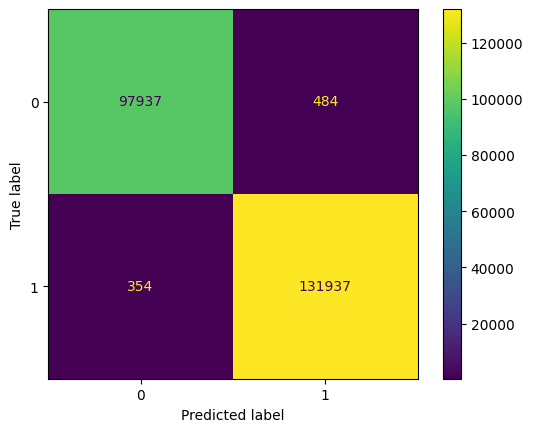

In [186]:
# Confusion matrix clean display
best_cm = confusion_matrix(y_new, best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm)
disp.plot(values_format='d')

In [187]:
# Get CM values and put into dataframe for Tableau
best_tn, best_fp, best_fn, best_tp = confusion_matrix(y_new, best_pred).ravel()

best_cm_df = pd.DataFrame([{
    'Name': "RandomForest",
    'True Negative (TN)': best_tn,
    'False Positive (FP)': best_fp,
    'False Negative (FN)': best_fn,
    'True Positive (TP)': best_tp
}])


In [188]:
# Metric calculations
print(f"Accuracy Score: {accuracy_score(y_new, best_pred)}")
print(f"Precision Score: {precision_score(y_new, best_pred)}")
print(f"Recall Score: {recall_score(y_new, best_pred)}")
print(f"F1-Score: {f1_score(y_new, best_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_new, best_pred)}")

Accuracy Score: 0.9963677658726031
Precision Score: 0.996344990598168
Recall Score: 0.9973240810032429
F1-Score: 0.9968342953851733
ROC AUC Score: 0.9962032156573299


In [189]:
best_metrics_df = pd.DataFrame([{
    'Name': "RandomForest",
    'Accuracy': accuracy_score(y_new, best_pred),
    'Precision': precision_score(y_new, best_pred),
    'Recall': recall_score(y_new, best_pred),
    'F1': f1_score(y_new, best_pred),
    'ROC AUC': roc_auc_score(y_new, best_pred)
}])
               

In [190]:
# Get best model and preprocessor for feature importance extraction
model = best_model.named_steps['model']
preprocessor = best_model.named_steps['prep']

# Category and text features
cat_features = preprocessor.named_transformers_['cat'].named_steps['encode'].get_feature_names_out(['TLD'])
text_features = preprocessor.named_transformers_['text'].named_steps['tfidf'].get_feature_names_out()

# Combine
feature_names = (
    preprocessor.transformers_[0][2] +  # numerical columns
    preprocessor.transformers_[1][2] +  # boolean columns
    cat_features.tolist() +
    text_features.tolist()
)

In [191]:
# Get the importance
importances = model.feature_importances_

In [192]:
# Combine importance with features
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [193]:
print(feature_importance.head(10))
#print(feature_importance.tail(20))

                       Feature  Importance
29                     IsHTTPS    0.554351
6             ObfuscationRatio    0.111241
22                 NoOfSelfRef    0.110967
5           NoOfObfuscatedChar    0.063572
4                NoOfSubDomain    0.036248
14  NoOfOtherSpecialCharsInURL    0.033392
15       SpacialCharRatioInURL    0.014184
24             NoOfExternalRef    0.013604
16                  LineOfCode    0.010016
2           URLSimilarityIndex    0.007045


In [194]:
feature_importance.to_csv('Data/Results/Feature_Importance.csv', index=False)

## Pickeling

In [195]:
with open('RF_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

## Baseline Heuristic Implementation

In [196]:
# Basic calculations for phishing URL's
def heuristic_phishing(url):
    # If URL length is bigger than 75 characters = phishing
    if len(url) > 75:
        return 0  # phishing
    #If it contains an @ sign = phishing
    if '@' in url:
        return 0
    # if more than 3 . = phishing
    if url.count('.') > 3:
        return 0
    # If the TLD ends with any of the three below = phishing
    suspicious_tlds = ['.xyz', '.top', '.club']
    if any(url.endswith(tld) for tld in suspicious_tlds):
        return 0
    # checks for IP address after HTTP[s] = phishing
    if re.match(r'http[s]?://(\d{1,3}\.){3}\d{1,3}', url):
        return 0
    return 1  # legitimate

In [197]:
# Copy original DF of tested URL's
heuristic_df = filtered_new_df.copy()

In [198]:
# Claculate heuristic results
heuristic_df['prediction'] = heuristic_df['URL'].apply(heuristic_phishing)

heuristic_df.to_csv("Data/Results/Heuristic_results.csv", index=False)

Heuristic Accuracy: 0.6448515898609521
Heuristic Precision: 0.6194967060923053
Heuristic Recall: 0.9866355232026366
Heuristic F1-Score: 0.7611047777878204
Heuristic ROC AUC Score: 0.5860418753575288


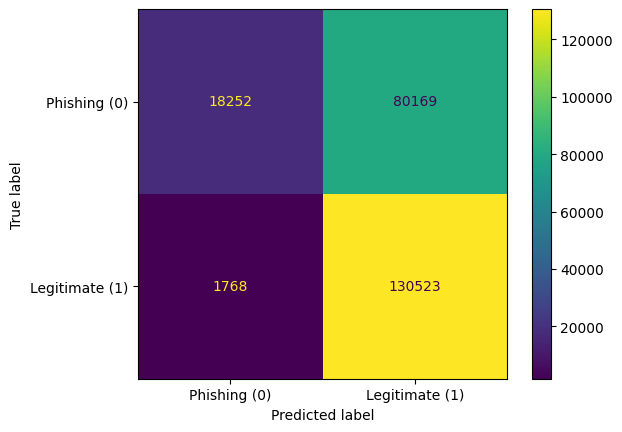

In [199]:
# Comparison metrics
h_true = heuristic_df['label']
h_pred = heuristic_df['prediction']

print("Heuristic Accuracy:", accuracy_score(h_true, h_pred))
print("Heuristic Precision:", precision_score(h_true, h_pred))
print("Heuristic Recall:", recall_score(h_true, h_pred)) #Recall is good since most are getting predicted as legitimate
print("Heuristic F1-Score:", f1_score(h_true, h_pred))
print("Heuristic ROC AUC Score:", roc_auc_score(h_true, h_pred))

# Confusion matrix
h_cm = confusion_matrix(h_true, h_pred)
h_disp = ConfusionMatrixDisplay(confusion_matrix=h_cm, display_labels=['Phishing (0)', 'Legitimate (1)'])
h_disp.plot(values_format='d')

In [200]:
# Put heuristic metrics into Dataframe for Tableau
h_metrics_df = pd.DataFrame([{
    'Name': "Heuristic",
    'Accuracy': accuracy_score(h_true, h_pred),
    'Precision': precision_score(h_true, h_pred),
    'Recall': recall_score(h_true, h_pred),
    'F1': f1_score(h_true, h_pred),
    'ROC AUC': roc_auc_score(h_true, h_pred)
}])
         

In [201]:
# Combine best model DF and heuristic approach DF
metric_df = pd.concat([best_metrics_df, h_metrics_df], ignore_index=True)

# write results to data/results folder
metric_df.to_csv("Data/Results/Metrics_Results.csv")

In [202]:
# Convert CM to a dataframe
h_tn, h_fp, h_fn, h_tp = confusion_matrix(h_true, h_pred).ravel()
h_cm_df = pd.DataFrame([{
    'Name': "Heuristic",
    'True Negative (TN)': h_tn,
    'False Positive (FP)': h_fp,
    'False Negative (FN)': h_fn,
    'True Positive (TP)': h_tp
}])


In [203]:
# Combine model and heuristic approach to one DF
cm_df = pd.concat([h_cm_df, best_cm_df], ignore_index=True)

# write results to CSV in data/results folder
cm_df.to_csv("Data/Results/Confusion_Matrix_Results.csv", index=False)

## Creating Function for Testing

In [204]:
# Function for predicting a URL is phishing or Legitimate.  Can take in a string or a list of URL's
def predict_phishing(url, model=best_model):
    islist = True
    if isinstance(url, str):
        islist = False
        urls = ["https://dk;afkjf;ajfd;.com/"]
        urls.append(url)
    else:
        urls = url

    url_dataset = []
    for link in urls:
        extractor = PhishingFeatureExtractor(link)
        features = extractor.to_dict()
        features['URL'] = link
        url_dataset.append(features)

    # Convert list of dicts to DataFrame
    df_features = pd.DataFrame(url_dataset)

    # Predict on the whole batch
    predictions = model.predict(df_features)
    probabilities = model.predict_proba(df_features)

    # Create mapping for predictions
    label_map = {0: "Phishing", 1: "Legitimate"}
    
    # Add predictions and probabilities to the DataFrame
    result_df = pd.DataFrame({
        'URL': df_features['URL'],
        'prediction': predictions,
        'probability': probabilities.max(axis=1)
    })

    #Remove Dummy from list if single URL
    if not islist:
        result_df = result_df.iloc[1:].reset_index(drop=True)

    # Map predictions
    result_df['prediction'] = result_df['prediction'].map(label_map)
    
    return result_df


In [205]:
url_list = ['https://www.google.com', 'https://www.yahoo.com']

result = predict_phishing('https://www.google.com')
result2 = predict_phishing(url_list)

Request failed: HTTPSConnectionPool(host='dk;afkjf;ajfd;.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6b066f2210>: Failed to resolve 'dk;afkjf;ajfd;.com' ([Errno -2] Name or service not known)"))
Redirect check failed: HTTPSConnectionPool(host='dk;afkjf;ajfd;.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6c470c77d0>: Failed to resolve 'dk;afkjf;ajfd;.com' ([Errno -2] Name or service not known)"))
Error checking self redirects for https://dk;afkjf;ajfd;.com/: HTTPSConnectionPool(host='dk;afkjf;ajfd;.com', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0xff6b06036ed0>: Failed to resolve 'dk;afkjf;ajfd;.com' ([Errno -2] Name or service not known)"))


In [206]:
print(result)

                      URL  prediction  probability
0  https://www.google.com  Legitimate          1.0


In [207]:
print(result2)

                      URL  prediction  probability
0  https://www.google.com  Legitimate     1.000000
1   https://www.yahoo.com  Legitimate     0.996652


## Conclusion

## Conclusion - Testing update

In [209]:
testing_df = pd.read_csv("Data/more_testing_data.csv")

In [210]:
X_p_test = testing_df.drop(columns=['label'])
y_p_test = testing_df['label']

y_p_pred = best_model.predict(X_p_test)

In [211]:
print(classification_report(y_p_test, y_p_pred, target_names=['Phishing', 'Legitimate']))

              precision    recall  f1-score   support

    Phishing       0.99      0.98      0.99      1999
  Legitimate       0.98      0.99      0.99      2000

    accuracy                           0.99      3999
   macro avg       0.99      0.99      0.99      3999
weighted avg       0.99      0.99      0.99      3999



Model Test 2 -  Accuracy: 0.9852463115778944
Model Test 2 -  Precision: 0.9825957235206365
Model Test 2 -  Recall: 0.988
Model Test 2 -  F1-Score: 0.9852904512590377
Model Test 2 -  ROC AUC Score: 0.9852456228114057


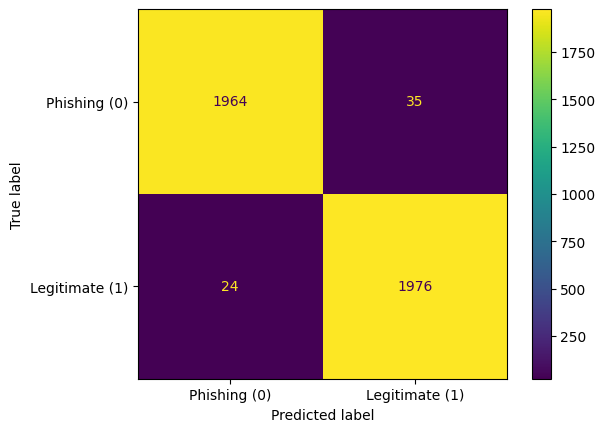

In [212]:
print("Model Test 2 -  Accuracy:", accuracy_score(y_p_test, y_p_pred))
print("Model Test 2 -  Precision:", precision_score(y_p_test, y_p_pred))
print("Model Test 2 -  Recall:", recall_score(y_p_test, y_p_pred)) #Recall is good since most are getting predicted as legitimate
print("Model Test 2 -  F1-Score:", f1_score(y_p_test, y_p_pred))
print("Model Test 2 -  ROC AUC Score:", roc_auc_score(y_p_test, y_p_pred))

# Confusion matrix
model_p_cm = confusion_matrix(y_p_test, y_p_pred)
model_p_disp = ConfusionMatrixDisplay(confusion_matrix=model_p_cm, display_labels=['Phishing (0)', 'Legitimate (1)'])
model_p_disp.plot(values_format='d')